# Analytical solutions of leaf energy balance
Based on the following paper:
Schymanski, S.J. and Or, D. (2016): [Leaf-scale experiments reveal important omission in the Penman-Monteith equation.](http://www.hydrol-earth-syst-sci-discuss.net/hess-2016-363/) Hydrology and Earth System Sciences Discussions, p.1–33. doi: 10.5194/hess-2016-363.

Author: Stan Schymanski (stan.schymanski@env.ethz.ch)

This worksheet relies on definitions provided in Worksheets [Worksheet_setup](Worksheet_setup.ipynb) and [leaf_enbalance_eqs](Leaf_enbalance_eqs.ipynb).

In [1]:
# The below updates sympy, downloads essm and prepares for import. Uncomment if running notebook on Hydroshare
#!/opt/conda/bin/pip install --upgrade sympy
#!git clone -b python3_sympy1.3 https://github.com/schymans/essm.git
#import sys
#sys.path.append('essm')


In [2]:
from __future__ import division
from IPython.display import display
#init_printing(use_latex='mathjax')  # This causes mathjax to render all output
from sympy import diff, Eq, exp, init_printing, log, solve, sqrt, Symbol, symbols
init_printing() 
from sympy.printing import StrPrinter
StrPrinter._print_Quantity = lambda self, expr: str(expr.abbrev)    # displays short units (m instead of meter)

In [3]:
# Using environmental science for symbolic math, see https://github.com/environmentalscience/essm
from essm.variables._core import BaseVariable, Variable
from essm.equations import Equation
from essm.equations.physics.thermodynamics import *
from essm.equations.leaf.energy_water import *
from essm.variables.units import derive_unit, SI, Quantity
from essm.variables.utils import replace_defaults, replace_variables

/home/stan/Programs/essm/essm/variables/_core.py:89: UserWarning: "essm.variables.physics.thermodynamics:Gr" will be overridden by "essm.variables.leaf.energy_water:<class 'essm.variables.leaf.energy_water.Gr'>"
  instance[expr] = instance
/home/stan/Programs/essm/essm/variables/_core.py:89: UserWarning: "essm.variables.physics.thermodynamics:h_c" will be overridden by "essm.variables.leaf.energy_water:<class 'essm.variables.leaf.energy_water.h_c'>"
  instance[expr] = instance


In [4]:
# Import all variables related to above equations into global name space
globals().update(**{str(v): v for v in Variable.__registry__})

# Copy devault values into cdict and ammend
cdict = Variable.__defaults__.copy()
cdict[Pr] = 0.71   # Prandtl number for air

In [5]:
def var2(name, doc='', units=1, domain1='real', latexname='', value=False):
    '''
    Creates a symbolic variable in the given domain (standard:'real') and with the given 
    doc, units and default value.
    Note that the information passed as
    domain1 is saved as an assumption, e.g. 'a is read'. All assumptions can be viewed as a
    list, using the command assumptions().
    Usage example: 
        var2('x', 'Distance' , units=meter, domain1 = 'positive', latexname = 'x_{1-2}', value = 1.0)
    '''
    StrPrinter._print_Quantity = lambda self, expr: str(expr.name)
    if not latexname:
        latexname = name
    if value:
        commandstring = "{0} = type('{0}', (Variable,), {{'__doc__': '{1}', 'unit': {2}, 'domain': '{3}', \
'latex_name': r'{4}', 'default': {5}}})".format(name, doc, units, domain1, latexname, value)
    else:
        commandstring = "{0} = type('{0}', (Variable,), {{'__doc__': '{1}', 'unit': {2}, 'domain': '{3}', \
'latex_name': r'{4}'}})".format(name, doc, units, domain1, latexname)
    exec(commandstring)
    globals().update({name: locals()[name]})
    StrPrinter._print_Quantity = lambda self, expr: str(expr.abbrev)

## Definition of additional variables
In addition to variables defined in Worksheet Leaf_enbalance_eqs, we need a few more, as defined below.
All variables are also listed in a [Table](#Table-of-symbols) at the end of this document.

In [6]:
from sympy.physics.units import joule, J, kelvin, K, meter, m, pascal, Pa, second, s
var2('beta_B', 'Bowen ratio (sensible/latent heat flux)', 1/1, latexname = r'\beta_B')
var2('Delta_eTa', 'Slope of saturation vapour pressure at air temperature', pascal/kelvin, latexname = r'\Delta_{e_{Ta}}') 
var2('epsilon', 'Water to air molecular weight ratio (0.622)', value = 0.622, latexname=r'\epsilon')
var2('E_w', 'Latent heat flux from a wet surface',units=joule/second/meter**2)
var2('f_u', 'Wind function in Penman approach, f(u) adapted to energetic units', joule/(meter**2*pascal*second))
var2('gamma_v', 'Psychrometric constant', pascal/kelvin, latexname = r'\gamma_v')
class n_MU(Variable):
    """n=2 for hypostomatous, n=1 for amphistomatous leaves"""
    expr = a_sh/a_s
    latex_name = r'n_{MU}'
var2('r_a', 'One-sided boundary layer resistance to heat transfer ($r_H$ in \citet[][P. 231]{monteith_principles_2013})', second/meter)
var2('r_v', 'One-sided leaf BL resistance to water vapour, \citep[][Eqs. 11.3 and 13.16]{monteith_principles_2013}', second/meter, latexname = 'r_{v}')
var2('r_s', 'Stomatal resistance to water vapour \citep[][P. 231]{monteith_principles_2013}', second/meter)
var2('S', 'Factor representing stomatal resistance in \citet{penman_physical_1952}')
#globals().update(**{str(v): v for v in Variable.__registry__})
beta_B

In [7]:
def define_equation(name, equ, doc=''):
    """Define Equation based on equality."""
    print(name)
    commandstring = "{0} = type('{0}', (Equation,), {{'__doc__': '{2}', 'expr': {1}}})".format(name, equ, doc)
    print(commandstring)
    exec(commandstring)
    globals().update({name: locals()[name]})
    return globals()[name]

In [8]:
Delta_eTa

In [9]:
f_u = type('f_u', (Variable,), {'__doc__': 'Wind function in Penman approach, f(u) adapted to energetic units', 'unit': J/(Pa*m**2*s), 'domain': 'real', 'latex_name': r'f_u'})

/home/stan/Programs/essm/essm/variables/_core.py:89: UserWarning: "essm.variables._core:f_u" will be overridden by "essm.variables._core:<class 'essm.variables._core.f_u'>"
  instance[expr] = instance


In [10]:
f_u

In [11]:
Eq(E_w, f_u*(P_wl - P_wa))

In [12]:
define_equation('eq_Ew_fu', Eq(E_w, f_u*(P_wl - P_wa)), doc="Penman water vapour diffusion.")

eq_Ew_fu
eq_Ew_fu = type('eq_Ew_fu', (Equation,), {'__doc__': 'Penman water vapour diffusion.', 'expr': Eq(E_w, f_u*(-P_wa + P_wl))})


eq_beta_B
eq_beta_B = type('eq_beta_B', (Equation,), {'__doc__': 'Penman Bowen ratio.', 'expr': Eq(beta_B, gamma_v*(-T_a + T_l)/(-P_wa + P_wl))})


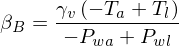

In [13]:
define_equation('eq_beta_B', Eq(beta_B, gamma_v*(T_l - T_a)/(P_wl - P_wa)), doc="Penman Bowen ratio.")

In order to eliminate $T_l$, Penman introduced a term for the ratio of the vapour pressure difference between the surface and the saturation vapour pressure at air temperature ($P_{was}$) to the temperature difference between the surface and the air:
##### {eq_Penman_ass}
$$ \Delta_{eTa} = \frac{P_{wl} - P_{was}}{T_l - T_a}$$

and he proposed to approximate this term by the slope of the saturation vapour pressure curve evaluated at air temperature, which can be obtained by substitution of $T_a$ for $T_l$ and differentiation of Eq. eq_Pwl with respect to $T_a$:
##### {eq_Deltaeta_Ta}
$$\Delta_{eTa} = \frac{611 \lambda_E M_w \exp \left( \frac{\lambda_E M_w}{R_{mol}} \left( \frac{1}{273} - \frac{1}{T_a} \right) \right)}{R_{mol} T_a^2}$$

For further discussion of the meaning of this assumption, please refer to \citet{mallick_surface_2014}.

## Penman (1948)
In order to obtain analytical expressions for the different leaf energy balance components, one would need to solve the leaf energy balance equation for leaf temperature first. However, due to the non-linearities of the blackbody radiation and the saturation vapour pressure equations, an analytical solution has not been found yet. \citet{penman_natural_1948} proposed a work-around, which we reproduced below, adapted to our notation and to a wet leaf, while Penman's formulations referred to a wet soil surface. He formulated evaporation from a wet surface as a diffusive process driven by the vapour pressure difference near the wet surface and in the free air:
##### {eq_Ew_fu}
$$E_{w} = f_u (P_{wl} - P_{wa})$$

where $E_w$ (J~s$^{-1}$~m$^{-2}$) is the latent heat flux from a wet surface and $f_u$ is commonly referred to as the wind function. Penman then defined the Bowen ratio as (Eq. 10 in \citet{penman_natural_1948}):
##### {eq_beta_B}
$$\beta_B = H_l/E_w = \gamma_v \frac{T_l - T_a}{P_{wl} - P_{wa}}$$

where $H_l$ is the sensible heat flux and $\gamma_v$ is the psychrometric constant, referring to the ratio between the transfer coefficients for sensible heat and that for water vapour.

eq_Penman_ass
eq_Penman_ass = type('eq_Penman_ass', (Equation,), {'__doc__': '', 'expr': Eq(Delta_eTa, (-P_was + P_wl)/(-T_a + T_l))})


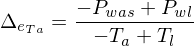

In [14]:
define_equation('eq_Penman_ass', Eq(Delta_eTa, (P_wl - P_was)/(T_l - T_a)))

eq_Pwas_Ta
eq_Pwas_Ta = type('eq_Pwas_Ta', (Equation,), {'__doc__': '', 'expr': Eq(P_was, p_CC1*exp(-M_w*lambda_E*(-1/p_CC2 + 1/T_a)/R_mol))})


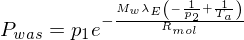

In [15]:
define_equation('eq_Pwas_Ta', Eq(P_was, eq_Pwl.rhs.subs(T_l, T_a)))

eq_Deltaeta_T
eq_Deltaeta_T = type('eq_Deltaeta_T', (Equation,), {'__doc__': '', 'expr': Eq(Delta_eTa, M_w*lambda_E*p_CC1*exp(-M_w*lambda_E*(-1/p_CC2 + 1/T_a)/R_mol)/(R_mol*T_a**2))})


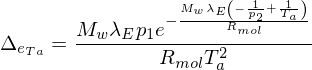

In [16]:
define_equation('eq_Deltaeta_T', Eq(Delta_eTa, diff(eq_Pwl.rhs.subs(T_l, T_a), T_a)))

Susbstitution of Eq. {eq_Penman_ass} in Eq. {eq_beta_B} yields (Eq. 15 in \citet{bowen_ratio_1926}):
##### {eq_betaB_Pwas}
$$\beta_B = \frac{\gamma_v}{\Delta_{eTa}}\frac{(P_{wl} - P_{was})}{(P_{wl} - P_{wa})}$$

Substituting $E_w$ for $E_l$ and inserting $H_l = \beta_B E_w$ (Eq. {eq_beta_B}) into the energy balance equation (Eq. {eq_Rs_enbal}) and solving for $E_w$ gives:
##### {eq_Ew_betaB}
$$E_w = \frac{R_s - R_{ll}}{\beta_B + 1}$$

Substitution of Eq. {eq_betaB_Pwas} into Eq. {eq_Ew_betaB}, equating with Eq. {eq_Ew_fu} and solving for $P_{wl}$ gives:
##### {eq_Pwl_fu}
$$P_{wl} = \frac{f_u (\Delta_{eTa} P_{wa} + \gamma_v P_{was}) + \Delta_{eTa} (R_s - R_{ll})}
{f_u (\Delta_{eTa} + \gamma_v)}$$

Now, insertion of Eq. {eq_Pwl_fu} into Eq. {eq_Ew_fu} gives the so-called "Penman equation" :
##### {eq_Ew_P}
$$E_w = \frac{\Delta_{eTa}(R_s - R_{ll}) + f_u \gamma_v (P_{was} - P_{wa})}
{\Delta_{eTa} + \gamma_v}$$


Eq. {eq_Ew_P} is equivalent to Eq 16 in \citet{penman_natural_1948}, but Eq. 17 in \citet{penman_natural_1948}, which should be equivalent to Eq. {eq_Pwl_fu}, has $P_{wl}$ ($e_s$ in Penman's notation) on both sides, so it seems to contain an error. In his derivations, Penman expressed $R_s - R_{ll}$ as "net radiant energy available at surface" and pointed out that the above two equations can be used to estimate $E_l$ and $T_l$ from air conditions only. This neglects the fact that $R_{ll}$ is also a function of the leaf temperature. To estimate surface temperature, Eq. {eq_Pwl_fu} can be inserted into Eq. {eq_Penman_ass} and solved for $T_l$, yielding:
##### {eq_Tl_P}
$$T_l = \frac{R_s - R_{ll} + f_u (\gamma_v T_a + \Delta_{eTa} T_a + P_{wa} - P_{was})}{f_u(\gamma_v + \Delta_{eTa})}$$


eq_betaB_Pwas
eq_betaB_Pwas = type('eq_betaB_Pwas', (Equation,), {'__doc__': '', 'expr': Eq(beta_B, gamma_v*(P_was - P_wl)/(Delta_eTa*(P_wa - P_wl)))})


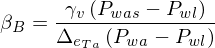

In [17]:
soln = solve([eq_beta_B, eq_Penman_ass], beta_B, T_l)
define_equation('eq_betaB_Pwas', Eq(beta_B, soln[beta_B]))

eq_Ew_betaB
eq_Ew_betaB = type('eq_Ew_betaB', (Equation,), {'__doc__': '', 'expr': Eq(E_w, (-R_ll + R_s)/(beta_B + 1))})


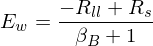

In [18]:
soln = solve(eq_Rs_enbal.subs({E_l: E_w, H_l: beta_B*E_w}), E_w)
define_equation('eq_Ew_betaB', Eq(E_w, soln[0]))

eq_Pwl_fu
eq_Pwl_fu = type('eq_Pwl_fu', (Equation,), {'__doc__': '', 'expr': Eq(P_wl, (Delta_eTa*P_wa*f_u - Delta_eTa*R_ll + Delta_eTa*R_s + P_was*f_u*gamma_v)/(f_u*(Delta_eTa + gamma_v)))})


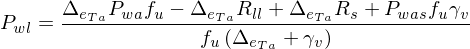

eq_Ew_P
eq_Ew_P = type('eq_Ew_P', (Equation,), {'__doc__': '', 'expr': Eq(E_w, (-Delta_eTa*R_ll + Delta_eTa*R_s - P_wa*f_u*gamma_v + P_was*f_u*gamma_v)/(Delta_eTa + gamma_v))})


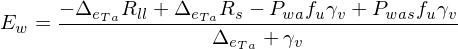

In [19]:
soln = solve([eq_betaB_Pwas, eq_Ew_betaB, eq_Ew_fu], P_wl, E_w, beta_B, dict=True)
define_equation('eq_Pwl_fu', Eq(P_wl, soln[0][P_wl]))
display(eq_Pwl_fu)
define_equation('eq_Ew_P', Eq(E_w, soln[0][E_w]))

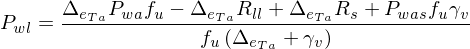

In [20]:
eq_Pwl_fu

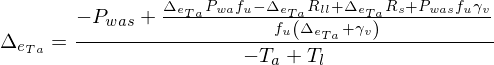

In [21]:
eq_Penman_ass.subs(eq_Pwl_fu.lhs, eq_Pwl_fu.rhs)

eq_Tl_P
eq_Tl_P = type('eq_Tl_P', (Equation,), {'__doc__': '', 'expr': Eq(T_l, (Delta_eTa*T_a - P_was + P_wl)/Delta_eTa)})


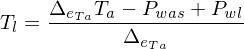

In [22]:
soln = solve([eq_Penman_ass, eq_Pwl_fu], T_l)
define_equation('eq_Tl_P', Eq(T_l, soln[T_l]))

eq_Tl_P
eq_Tl_P = type('eq_Tl_P', (Equation,), {'__doc__': '', 'expr': Eq(T_l, (Delta_eTa*T_a - P_was + P_wl)/Delta_eTa)})


/home/stan/Programs/essm/essm/equations/_core.py:107: UserWarning: "essm.equations._core:eq_Tl_P" will be overridden by "essm.equations._core:<class 'essm.equations._core.eq_Tl_P'>"
  instance[expr] = instance


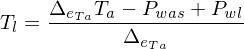

In [23]:
soln = solve([eq_Penman_ass,eq_Pwl_fu], T_l)
define_equation('eq_Tl_P', Eq(T_l, soln[T_l]))

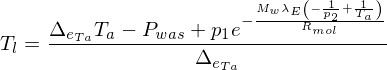

In [24]:
eq_Tl_P.subs(P_wl, eq_Pwl.rhs.subs({P_wl: P_was, T_l: T_a}))

eq_Tl_P
eq_Tl_P = type('eq_Tl_P', (Equation,), {'__doc__': '', 'expr': Eq(T_l, (Delta_eTa*T_a*f_u + P_wa*f_u - P_was*f_u - R_ll + R_s + T_a*f_u*gamma_v)/(f_u*(Delta_eTa + gamma_v)))})


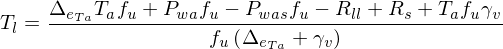

eq_Pwl_P_wet
eq_Pwl_P_wet = type('eq_Pwl_P_wet', (Equation,), {'__doc__': '', 'expr': Eq(P_wl, (Delta_eTa*P_wa*f_u - Delta_eTa*R_ll + Delta_eTa*R_s + P_was*f_u*gamma_v)/(f_u*(Delta_eTa + gamma_v)))})


/home/stan/Programs/essm/essm/equations/_core.py:107: UserWarning: "essm.equations._core:eq_Pwl_fu" will be overridden by "essm.equations._core:<class 'essm.equations._core.eq_Pwl_P_wet'>"
  instance[expr] = instance


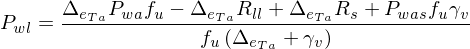

In [25]:
soln = solve([eq_Penman_ass, eq_Pwl_fu], T_l, P_wl)
define_equation('eq_Tl_P', Eq(T_l, soln[T_l]))
display(eq_Tl_P)
define_equation('eq_Pwl_P_wet', Eq(P_wl, soln[P_wl]))

eq_Tl_P1
eq_Tl_P1 = type('eq_Tl_P1', (Equation,), {'__doc__': '', 'expr': Eq(T_l, M_w*lambda_E*p_CC2/(M_w*lambda_E - R_mol*p_CC2*log(P_wl/p_CC1)))})


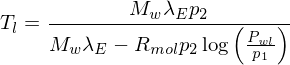

In [26]:
# Alternative approach to get T_l, followoing Eq. 17 in Penman (1948), which is eq_Pwl_P_wet
soln = solve([eq_Pwl, eq_Pwl_P_wet], T_l)
define_equation('eq_Tl_P1', Eq(T_l, soln[T_l]))

## Introduction of stomatal resistance by \citet{penman_physical_1952}
To account for stomatal resistance to vapour diffusion, \citet{penman_physical_1952} introduced an additional multiplicator ($S$) in Eq. {eq_Ew_fu} \citep[Appendix 13]{penman_physical_1952}:
##### {eq_El_fu_S}
$$E_l = f_u S (P_{wl} - P_{wa})$$

where $S=1$ for a wet surface (leading to Eq. {eq_Ew_fu}) and $S<1$ in the presence of significant stomatal resistance. 

In accordance with Eqs. {eq_Ew_fu} and {eq_beta_B}, $H_l$ can be expressed as \citep[Appendix 13]{penman_physical_1952}:
##### {eq_Hl_Tl_P52}
$$H_l = \gamma_v f_u (T_l - T_a)$$

Substitution of Penman's simplifying assumption ($T_l - T_a = (P_{wl} - P_{was})/\Delta_{eT}$, Eq. {eq_Penman_ass}) is the first step to eliminating $T_l$:
##### {eq_Hl_Pwl_P52}
$$H_l = \frac{\gamma_v f_u (P_{wl} - P_{was})}{\Delta_{eTa}}$$

A series of algebraic manipulations involving Eqs. {eq_El_fu_S}, {eq_Hl_Pwl_P52} and {eq_Rs_enbal}  and the resulting Eq. {eq_El_P52} is given in \citet[Appendix 13]{penman_physical_1952}. When solving Eqs. {eq_El_fu_S}, {eq_Hl_Pwl_P52} and {eq_Rs_enbal} for $E_l$, $H_l$ and $P_{wl}$, we obtained:

##### {eq_El_P52}
$$E_l = \frac{S \Delta_{eTa}(R_s - R_{ll}) + S \gamma_v f_u (P_{was} - P_{wa})}{S \Delta_{eT} + \gamma_v}  $$

##### {eq_Hl_P52}
$$H_{l} = \frac{\gamma_{v} \left(R_s - {R_{ll}}\right) + S \gamma_{v} f_{u} \left({P_{wa}} - {P_{was}}\right)}
{S \Delta_{eTa} + \gamma_{v}}$$

##### {eq_Pwl_P52}
$$P_{wl} = \frac{\left(\Delta_{eTa}/f_u\right) \left(R_s - {R_{ll}}\right)+  \left({S \Delta_{eTa}} {P_{wa}} + \gamma_{v} {P_{was}}\right)}
{{S \Delta_{eTa}} + \gamma_{v}}$$
\end{equation}

In [27]:
define_equation('eq_El_fu_S', Eq(E_l, f_u*S*(P_wl - P_wa)))

eq_El_fu_S
eq_El_fu_S = type('eq_El_fu_S', (Equation,), {'__doc__': '', 'expr': Eq(E_l, S*f_u*(-P_wa + P_wl))})


In [28]:
soln = solve([Eq(H_l/E_w, eq_beta_B.rhs), eq_Ew_fu], H_l, P_wl, dict=True)
define_equation('eq_Hl_Tl_P52', Eq(H_l, soln[0][H_l]))

eq_Hl_Tl_P52
eq_Hl_Tl_P52 = type('eq_Hl_Tl_P52', (Equation,), {'__doc__': '', 'expr': Eq(H_l, f_u*gamma_v*(-T_a + T_l))})


eq_Hl_Pwl_P52
eq_Hl_Pwl_P52 = type('eq_Hl_Pwl_P52', (Equation,), {'__doc__': '', 'expr': Eq(H_l, -f_u*gamma_v*(P_was - P_wl)/Delta_eTa)})


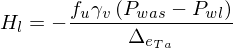

In [29]:
soln = solve([eq_Hl_Tl_P52, eq_Penman_ass], H_l, T_l)
define_equation('eq_Hl_Pwl_P52', Eq(H_l, soln[H_l]))

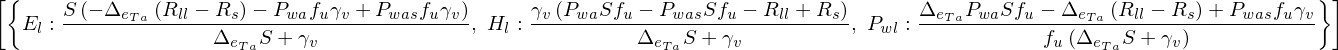

In [30]:
soln = solve([eq_Hl_Pwl_P52,eq_El_fu_S, eq_Rs_enbal], E_l, H_l, P_wl, dict=True)
soln

In [31]:
#Saving all results to equations
soln0 = soln[0]
for key in soln0.keys():
    name = 'eq_' + str(key).replace('_', '') + '_P52'
    print(name)
    define_equation(name, Eq(key, soln0[key]))

eq_El_P52
eq_El_P52
eq_El_P52 = type('eq_El_P52', (Equation,), {'__doc__': '', 'expr': Eq(E_l, S*(-Delta_eTa*(R_ll - R_s) - P_wa*f_u*gamma_v + P_was*f_u*gamma_v)/(Delta_eTa*S + gamma_v))})
eq_Hl_P52
eq_Hl_P52
eq_Hl_P52 = type('eq_Hl_P52', (Equation,), {'__doc__': '', 'expr': Eq(H_l, gamma_v*(P_wa*S*f_u - P_was*S*f_u - R_ll + R_s)/(Delta_eTa*S + gamma_v))})
eq_Pwl_P52
eq_Pwl_P52
eq_Pwl_P52 = type('eq_Pwl_P52', (Equation,), {'__doc__': '', 'expr': Eq(P_wl, (Delta_eTa*P_wa*S*f_u - Delta_eTa*(R_ll - R_s) + P_was*f_u*gamma_v)/(f_u*(Delta_eTa*S + gamma_v)))})


### Analytical solutions for leaf temperature, $f_u$, $\gamma_v$ and $S$

Equation {eq_Pwl_P52} can be inserted into Eq. {eq_Penman_ass} and solved for leaf temperature to yield:
##### {eq_Tl_p52}
$$T_{l} = T_{a} + \frac{R_{s} - R_{ll} - S f_{u}(P_{was}-P_{wa})}
{f_{u} \left(S \Delta_{eT} + \gamma_{v}\right) }$$


\citet{penman_physical_1952} proposed to obtain values of $f_u$ and $S$ for a plant canopy empirically and described ways how to do this. However, for a single leaf, $f_u$ and $S$ could also be obtained analytically from our detailed mass and heat transfer model. 

Comparison of Eq. {eq_El_fu_S} with Eq. {eq_Elmol_conv} (after substituting Eq. {eq_El}) reveals that $S$ is equivalent to:
##### {eq_S_gtwmol_fu}
$$S = \frac{M_{w} g_{tw,mol} \lambda_{E}}{P_{a} f_{u}}$$

where $f_u$ was defined by \citet{penman_natural_1948} as the transfer coeffient for wet surface evaporation, i.e. a function of the boundary layer conductance only. 

To find a solution for $f_u$, we first formulate $E_w$ as transpiration from a leaf where $g_{tw} = g_{bw}$, using Eqs. {eq_El}, {eq_Elmol_conv} and {eq_gtwmol_gtw_iso}:
##### {eq_Ew_conv}
$$E_w = \frac{\lambda_E M_w g_{bw}}{R_{mol} T_a} (P_{wl} - P_{wa})$$

Comparison of Eq. {eq_Ew_conv} with {eq_Ew_fu} gives $f_u$ as a function of $g_{bw}$:
##### {eq_fu_gbw}
$$f_u = g_{bw}\frac{\lambda_E M_w}{R_{mol} T_a}$$

Comparison between Eq. {eq_Hl_Tl_P52} and Eq. {eq_Hl} reveals that
##### {eq_gammav_hc_fu}
$$\gamma_v = \frac{a_{sh} h_c}{f_u},$$

and insertion of Eqs. {eq_fu_gbw} and {eq_gbw_hc} give $\gamma_v$ as a function of $a_{sh}$ and $a_s$:
##### {eq_gammav_as}
$$\gamma_{v} =a_{sh}/a_s \frac{{N_{Le}}^{\frac{2}{3}} {R_{mol}} T_{a} \rho_{a} c_{pa}}{\lambda_{E} M_{w}}$$

Now, we can insert Eqs. {eq_fu_gbw}, {eq_gtwmol_gtw_iso} and {eq_gtw} into Eq. {eq_S_gtwmol_fu} to obtain $S$ as a function of $g_{sw}$ and $g_{bw}$:
##### {eq_S_gsw_gbw}
$$S = \frac{g_{sw}}{g_{bw} + g_{sw}}$$

The above equation illustrates that $S$ is not just a function of stomatal conductance, but also the leaf boundary layer conductance, explaining why \citet{penman_physical_1952} found that $S$ depends on wind speed.

eq_Tl_P52
eq_Tl_P52 = type('eq_Tl_P52', (Equation,), {'__doc__': '', 'expr': Eq(T_l, (Delta_eTa*S*T_a*f_u + P_wa*S*f_u - P_was*S*f_u - R_ll + R_s + T_a*f_u*gamma_v)/(f_u*(Delta_eTa*S + gamma_v)))})


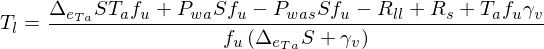

In [32]:
soln = solve([eq_Penman_ass, eq_Pwl_P52], T_l, P_wl)
name = 'eq_Tl_P52'
key = T_l
define_equation(name, Eq(key, soln[key]))

eq_S_gtwmol_fu
eq_S_gtwmol_fu = type('eq_S_gtwmol_fu', (Equation,), {'__doc__': '', 'expr': Eq(S, M_w*g_twmol*lambda_E/(P_a*f_u))})


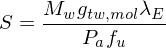

In [33]:
soln = solve([eq_El_fu_S, eq_El, eq_Elmol_conv], S, E_lmol, E_l)
name = 'eq_S_gtwmol_fu'
key = S
define_equation(name, Eq(key, soln[key]))

eq_gammav_hc_fu
eq_gammav_hc_fu = type('eq_gammav_hc_fu', (Equation,), {'__doc__': '', 'expr': Eq(gamma_v, a_sh*h_c/f_u)})


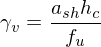

In [34]:
soln = solve([eq_Hl_Tl_P52, eq_Hl], H_l, gamma_v)
name = 'eq_gammav_hc_fu'
key = gamma_v
define_equation(name, Eq(key, soln[key]))

eq_Ew_conv
eq_Ew_conv = type('eq_Ew_conv', (Equation,), {'__doc__': '', 'expr': Eq(E_w, -M_w*g_bw*lambda_E*(P_wa - P_wl)/(R_mol*T_a))})


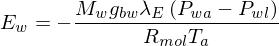

In [35]:
soln = solve([eq_El, eq_Elmol_conv, eq_gtwmol_gtw_iso], E_l, E_lmol, g_twmol)
name = 'eq_Ew_conv'
key = E_l
define_equation(name, Eq(E_w, soln[key].subs(g_tw, g_bw)))

eq_fu_gbw
eq_fu_gbw = type('eq_fu_gbw', (Equation,), {'__doc__': '', 'expr': Eq(f_u, M_w*g_bw*lambda_E/(R_mol*T_a))})


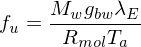

In [36]:
soln = solve([eq_Ew_conv, eq_Ew_fu], E_w, f_u)
name = 'eq_fu_gbw'
key = f_u
define_equation(name, Eq(key, soln[key]))

eq_gammav_hc_fu
eq_gammav_hc_fu = type('eq_gammav_hc_fu', (Equation,), {'__doc__': '', 'expr': Eq(gamma_v, a_sh*h_c/f_u)})


/home/stan/Programs/essm/essm/equations/_core.py:107: UserWarning: "essm.equations._core:eq_gammav_hc_fu" will be overridden by "essm.equations._core:<class 'essm.equations._core.eq_gammav_hc_fu'>"
  instance[expr] = instance


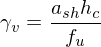

In [37]:
soln = solve([eq_Hl_Tl_P52, eq_Hl], H_l, gamma_v)
name = 'eq_gammav_hc_fu'
key = gamma_v
define_equation(name, Eq(key, soln[key]))

eq_gammav_as
eq_gammav_as = type('eq_gammav_as', (Equation,), {'__doc__': '', 'expr': Eq(gamma_v, Le**(2/3)*R_mol*T_a*a_sh*c_pa*rho_a/(M_w*a_s*lambda_E))})


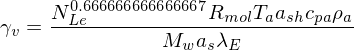

In [38]:
soln = solve([eq_gammav_hc_fu, eq_fu_gbw, eq_gbw_hc], gamma_v, f_u, g_bw, dict=True)
name = 'eq_gammav_as'
key = gamma_v
define_equation(name, Eq(key, soln[0][key]))

eq_S_gbw_gsw
eq_S_gbw_gsw = type('eq_S_gbw_gsw', (Equation,), {'__doc__': '', 'expr': Eq(S, g_sw/(g_bw + g_sw))})


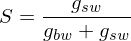

In [39]:
soln = solve([eq_S_gtwmol_fu, eq_fu_gbw, eq_gtwmol_gtw_iso, eq_gtw], S,f_u, g_twmol, g_tw, dict=True)
name = 'eq_S_gbw_gsw'
key = S
define_equation(name, Eq(key, soln[0][key]))

In [40]:
def dict_eq(*eqs):
    """
    Create dictionary of {eq.lhs: eq.rhs} of equations.
    """
    return {eq.lhs: eq.rhs for eq in eqs}

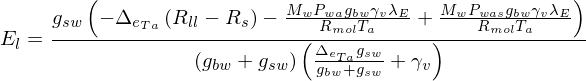

In [41]:
from essm.variables.utils import replace_variables
replace_variables(eq_El_P52, dict_eq(eq_S_gbw_gsw, eq_fu_gbw))

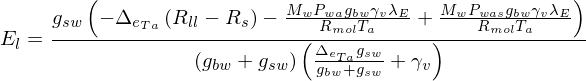

In [42]:
eq_El_P52.subs(dict_eq(eq_S_gbw_gsw, eq_fu_gbw))

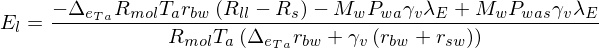

In [43]:
eq_El_P52.subs(dict_eq(eq_S_gbw_gsw, eq_fu_gbw)).subs({g_bw: 1/r_bw, g_sw: 1/r_sw}).simplify()

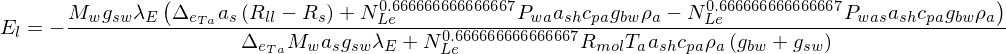

In [44]:
eq_El_P52.subs(dict_eq(eq_S_gbw_gsw, eq_fu_gbw)).subs(dict_eq(eq_gammav_as)).simplify()

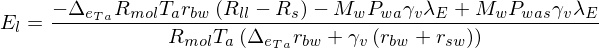

In [45]:
eq_El_P52.subs(dict_eq(eq_S_gbw_gsw, eq_fu_gbw)).subs({g_sw: 1/r_sw, g_bw: 1/r_bw}).simplify()

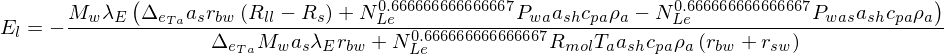

In [46]:
eq_El_P52.subs(dict_eq(eq_S_gbw_gsw, eq_fu_gbw)).subs({g_sw: 1/r_sw, g_bw: 1/r_bw}).subs(dict_eq(eq_gammav_as)).simplify()

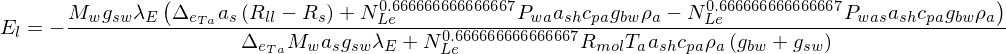

In [47]:
eq_El_P52.subs(dict_eq(eq_S_gbw_gsw, eq_fu_gbw, eq_gammav_as)).simplify()

## Penman-Monteith equation
\citet{monteith_evaporation_1965} re-derived Eq. {eq_Ew_P} using a  different set of arguments than Penman in his original derivation and arrived to an equivalent equation (Eq. 8 in \citet{monteith_evaporation_1965}):
##### {eq_Ew_PM1}
$$E_w = \frac{\Delta_{eTa}(R_s - R_{ll}) + \rho_a c_{pa} (P_{was} - P_{wa})/r_a}
{\Delta_{eTa} + \gamma_v} ,$$

where $r_a$ is the leaf boundary layer resistance to sensible heat flux.
Eq. {eq_Ew_PM1} is consistent with Eq. {eq_Ew_P} if Penman's wind function ($f_u$) is replaced by:
##### {eq_fu_ra_M}
$$f_u = \frac{\rho_a c_{pa}}{\gamma_v r_a}.$$


Monteith pointed out that the ratio between the conductance to sensible heat and the conductance to water vapour transfer, expressed in the psychrometric constant ($\gamma_v$) would be affected by stomatal resistance ($r_{sw}$) and hence proposed to replace the psychrometric constant by $\gamma_v^*$:
##### {eq_gammavs_M65}
$$\gamma_v^* = \gamma_v(1 + \frac{r_s}{r_a}),$$

leading to the so-called Penman-Monteith equation for transpiration:
##### {eq_El_PM2}
$$E_l = \frac{\Delta_{eTa}(R_s - R_{ll}) + \rho_a c_{pa} (P_{was} - P_{wa})/r_a}
{\Delta_{eTa} + \gamma_v \left(1 + \frac{r_{s}}{r_a}\right)} $$


More recently, \citet{monteith_principles_2013} pointed out that the difference between leaves with stomata on only one side and those with stomata on both sides can also be considered by further modifying $\gamma_v^*$ to:
##### {eq_gammavs_MU}
$$\gamma_v^* = n_{MU} \gamma_v (1 + r_s/r_a)$$

where $n_{MU} = 1$ for leaves with stomata on both sides and $n_{MU} = 2$ for leaves with stomata on one side, i.e. $n_{MU} = a_{sh}/a_s$ in our notation.
Insertion of Eq. {eq_gammavs_MU} into Eq. {eq_Ew_PM1} yields what we will call the Monteith-Unsworth (MU) equation, which only differs from the Penman-Monteith equation by the additional factor $n_{MU}$:
##### {eq_El_MU2}
$$E_l = \frac{\Delta_{eTa}(R_s - R_{ll}) + \rho_a c_{pa} (P_{was} - P_{wa})/r_a}
{\Delta_{eTa} + \gamma_v n_{MU} \left(1 + \frac{r_{s}}{r_a}\right)} $$

\citet{monteith_principles_2013} also provide a definition of $\gamma_v$ as:
##### {eq_gammav_MU}
$$\gamma_v = \frac{c_{pa} P_a}{\lambda_E \epsilon}$$

where $\epsilon$ is the ratio of molecular weights of water vapour and air (given by \citet{monteith_principles_2013} as 0.622). 
Note that Equation {eq_gammavs_MU} was derived based on the assumption that $r_a$ refers to one-sided resistance to sensible heat transfer \citep[P. 231]{monteith_principles_2013}, but $r_a$ in Eq. {eq_Ew_PM1} refers to total leaf boundary layer resistance for sensible heat flux, which, for a planar leaf, is half the one-sided value. This inconsistency will be further discussed in Section {sec_PM-incons}.

The molar mass of air is $M_a = \rho_a V_a/n_a$, while according to the ideal gas law, $V_a/n_a = R_{mol} T_a/P_a$, which yields for $\epsilon = M_w/M_a$:
##### {eq_epsilon}
$$\epsilon = \frac{M_w P_a}{R_{mol} T_a \rho_a}$$

Inserting Eqs. {eq_rhoa_Pwa_Ta}, {eq_PN2} and {eq_PO2} in the above, $T_a$ cancels out, and at standard atmospheric pressure of 101325 Pa, we obtain values for $\epsilon$ between 0.624 and 0.631 for vapour pressure ranging from 0 to 3000 Pa, compared to the value of 0.622 mentioned by \citet{monteith_principles_2013}.

eq_fu_ra_M
eq_fu_ra_M = type('eq_fu_ra_M', (Equation,), {'__doc__': '', 'expr': Eq(f_u, c_pa*rho_a/(gamma_v*r_a))})


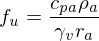

In [48]:
define_equation('eq_fu_ra_M', Eq(f_u, rho_a*c_pa/(gamma_v*r_a)))
display(eq_fu_ra_M)

J/(m**2*s)
J/(m**2*s)
eq_Ew_PM1
eq_Ew_PM1 = type('eq_Ew_PM1', (Equation,), {'__doc__': '', 'expr': Eq(E_w, (-Delta_eTa*R_ll + Delta_eTa*R_s - P_wa*c_pa*rho_a/r_a + P_was*c_pa*rho_a/r_a)/(Delta_eTa + gamma_v))})


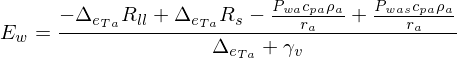

In [49]:
from essm.variables.units import derive_unit
print(derive_unit(eq_Ew_P.rhs.subs(dict_eq(eq_fu_ra_M))))
print(derive_unit(E_w))
define_equation('eq_Ew_PM1', Eq(E_w, eq_Ew_P.rhs.subs(dict_eq(eq_fu_ra_M))))
display(eq_Ew_PM1)

eq_gammavs_M65
eq_gammavs_M65 = type('eq_gammavs_M65', (Equation,), {'__doc__': '', 'expr': Eq(gamma_v, gamma_v*(1 + r_s/r_a))})


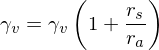

In [50]:
define_equation('eq_gammavs_M65', Eq(gamma_v, gamma_v*(1 + r_s/r_a)))
display(eq_gammavs_M65)

In [51]:
print(eq_Ew_PM1.subs(dict_eq(eq_gammavs_M65)).subs(E_w, E_l))

Eq(E_l, (-Delta_eTa*R_ll + Delta_eTa*R_s - P_wa*c_pa*rho_a/r_a + P_was*c_pa*rho_a/r_a)/(Delta_eTa + gamma_v*(1 + r_s/r_a)))


eq_El_PM2
eq_El_PM2 = type('eq_El_PM2', (Equation,), {'__doc__': '', 'expr': Eq(E_l, (-Delta_eTa*R_ll + Delta_eTa*R_s - P_wa*c_pa*rho_a/r_a + P_was*c_pa*rho_a/r_a)/(Delta_eTa + gamma_v*(1 + r_s/r_a)))})


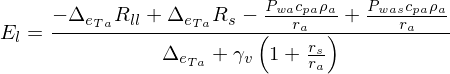

In [52]:
define_equation('eq_El_PM2', eq_Ew_PM1.subs(dict_eq(eq_gammavs_M65)).subs(E_w, E_l))
display(eq_El_PM2)

eq_gammavs_MU
eq_gammavs_MU = type('eq_gammavs_MU', (Equation,), {'__doc__': '', 'expr': Eq(gamma_v, gamma_v*n_MU*(1 + r_s/r_a))})


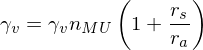

In [53]:
define_equation('eq_gammavs_MU', Eq(gamma_v, n_MU*gamma_v*(1 + r_s/r_a)))
display(eq_gammavs_MU)

eq_El_MU2
eq_El_MU2 = type('eq_El_MU2', (Equation,), {'__doc__': '', 'expr': Eq(E_l, (-Delta_eTa*R_ll + Delta_eTa*R_s - P_wa*c_pa*rho_a/r_a + P_was*c_pa*rho_a/r_a)/(Delta_eTa + gamma_v*n_MU*(1 + r_s/r_a)))})


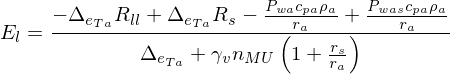

In [54]:
define_equation('eq_El_MU2', eq_Ew_PM1.subs({gamma_v: eq_gammavs_MU.rhs, E_w: E_l}))
display(eq_El_MU2)

eq_gammav_MU
eq_gammav_MU = type('eq_gammav_MU', (Equation,), {'__doc__': '', 'expr': Eq(gamma_v, P_a*c_pa/(epsilon*lambda_E))})


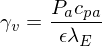

In [55]:
define_equation('eq_gammav_MU', Eq(gamma_v, c_pa*P_a/(lambda_E*epsilon)))
display(eq_gammav_MU)

eq_epsilon
eq_epsilon = type('eq_epsilon', (Equation,), {'__doc__': '', 'expr': Eq(epsilon, M_w*P_a/(R_mol*T_a*rho_a))})


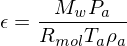

In [56]:
# Molar mass of air is M_a = rho_a*V_a/n_a, while V_a/n_a = R_mol*T_a/P_a, according to the ideal gas law
define_equation('eq_epsilon', Eq(epsilon, M_w/(rho_a*R_mol*T_a/P_a)))
display(eq_epsilon)

In [57]:
import matplotlib.pyplot as plt
from sympy import latex
from sympy import N
from numpy import arange
from essm.variables.units import derive_unit, SI, Quantity
from essm.variables.utils import markdown
def plot_expr(expr, xvar, yvar, xmin, xmax, clf=True, **args):
    '''Plot expression as function for variable from xmin to xmax.'''
    
    if clf:
        plt.close
        plt.clf
    xstep = (xmax - xmin)/100
    xvals = arange(xmin, xmax, xstep)
    yvals = [N(expr.subs(xvar, dummy)) for dummy in xvals]
    if isinstance(yvar, BaseVariable):
        ylabel1 = '$'+latex(yvar)+'$' + ' (' + markdown(yvar.definition.unit) + ')'
    else:
        if isinstance(yvar, str):
            ylabel1 = yvar
        else:
            raise ValueError('yvar must be a variable or a string.')
    plt.figure(**args)
    plt.plot(xvals, yvals)
    plt.xlabel('$'+latex(xvar)+'$' + ' (' + markdown(xvar.definition.unit) + ')')
    plt.ylabel(ylabel1)
    plt.show()

In [58]:
def plot_expr1(expr, yvar, xvar_min_max, fig1=None, format1='b-', label1=None, **args):
    '''Plot expression as function for variable from xmin to xmax.'''
    (xvar, xmin, xmax) = xvar_min_max
    if not fig1:
        plt.close
        plt.clf
        fig = plt.figure(**args)
    else: fig = fig1
    xstep = (xmax - xmin)/100
    xvals = arange(xmin, xmax, xstep)
    yvals = [N(expr.subs(xvar, dummy)) for dummy in xvals]
    if isinstance(yvar, BaseVariable):
        ylabel1 = '$'+latex(yvar)+'$' + ' (' + markdown(yvar.definition.unit) + ')'
    else:
        if isinstance(yvar, str):
            ylabel1 = yvar
        else:
            raise ValueError('yvar must be a variable or a string.')

    ax = fig.add_subplot(1, 1, 1)
    ax.plot(xvals, yvals, format1, label=label1)
    ax.set_xlabel('$'+latex(xvar)+'$' + ' (' + markdown(xvar.definition.unit) + ')')
    ax.set_ylabel(ylabel1)
    if fig1: ax.legend()
    return fig

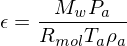

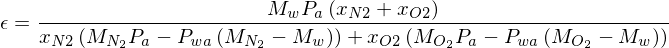

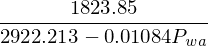

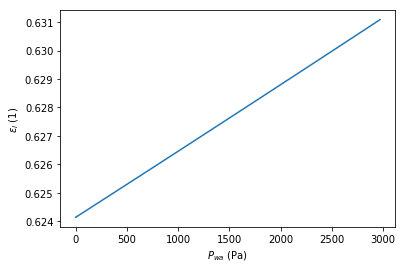

In [59]:
display(eq_epsilon)
display(eq_epsilon.subs(eq_rhoa).simplify())
expr = eq_epsilon.rhs.subs(dict_eq(eq_rhoa)).subs(cdict).subs(P_a, 101325)
display(expr)
plot_expr(expr, P_wa, epsilon_l, 0, 3000)

**The value of 0.622 given for $\epsilon$ is slightly too low, even for dry air! It depends only on air pressure and vapour pressure, not air temperature.**

### Relationships between resistances and conductances
As opposed to the formulations in Section {sec:enbal}, where sensible and latent heat transfer coefficients ($h_c$ and $g_{tw}$ respectively) translate leaf-air differences in temperature or vapour concentration to fluxes, resistances in the PM equation are defined in the context of \citep[Eqs. 13.16 and 13.20]{monteith_principles_2013}:
##### {eq_El_MU}
\begin{equation}
E_l = \frac{a_s \lambda_E\rho_a\epsilon}{P_a (r_v + r_s)} (P_{wl} - P_{wa})
\end{equation}
and 
##### {eq_Hl_MU}
\begin{equation}
H_l = \frac{a_{sh} \rho_a c_{pa}}{r_a}(T_l - T_a),
\end{equation}
where $r_v$ and $r_s$ are the one-sided leaf boundary layer and stomatal resistances to water vapour respectively, and $r_a$ is the one-sided leaf boundary layer resistance to sensible heat transfer. Note that the introduction of $a_s$, $a_{sh}$ and $r_s$ in Eqs. {eq_El_MU} and {eq_Hl_MU} is based on the description on P. 231 in \citet{monteith_principles_2013}, where the authors also assumed that $r_v \approx r_a$.

Comparison of Eq. {eq_El_MU} with Eq. {eq_Elmol} (after substitution of Eqs. {eq_Cwl} and {eq_Cwa} and insertion into Eq. {eq_El}), assuming isothermal conditions ($T_l = T_a$) and substituting Eq. {eq_epsilon} reveals that 
##### {eq_rv_gbw}
\begin{equation}
r_v = a_s/g_{bw},
\end{equation}
while comparison of Eq. {eq_Hl_MU} with Eq. {eq_Hl} reveals that
##### {eq_ra_hc}
\begin{equation}
r_a = \frac{\rho_a c_{pa}}{h_c}.
\end{equation}

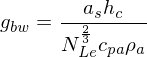

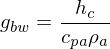

In [60]:
# According to Eq. 13.20 in Monteith_principles_2013, rho_a*c_pa/r_H = h_c, while he states below Eq. 13.32 
# that r_H = r_v approximately. This would imply that g_bw = 1/r_w = h_c/(rho_a*c_pa). Is this true?
display(eq_Hl)
display(eq_gbw_hc)
display(Eq(g_bw, h_c/(rho_a*c_pa)))

However, note that r_v is used in Eq. 13.16 on the vapour pressure gradient,
not on the concentration gradient as g_bw! He also uses: 
$E_l = \lambda_E \rho_a \epsilon/P_a (P_{wl} - P_{wa})/r_v)$, when formulating the equation for a wet surface evaporating on one side only.

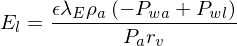

In [61]:
Eq(E_l, lambda_E*rho_a*epsilon/P_a*(P_wl - P_wa)/r_v)

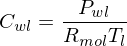

In [62]:
eq_Cwl

In [63]:
vdict = cdict.copy()
vdict[T_a] = 300
display(eq_Le.subs(dict_eq(eq_alphaa, eq_Dva)).subs(vdict))

**With Le = 0.89, $r_H = r_v$ would be approximately true only for $a_s = 1$**

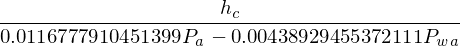

In [64]:
display(h_c/(rho_a*c_pa).subs(dict_eq(eq_rhoa_Pwa_Ta, eq_Le)).subs(dict_eq(eq_alphaa, eq_Dva,eq_PN2, eq_PO2)).subs(vdict))

eq_El_MU
eq_El_MU = type('eq_El_MU', (Equation,), {'__doc__': '', 'expr': Eq(E_l, a_s*epsilon*lambda_E*rho_a*(-P_wa + P_wl)/(P_a*(r_s + r_v)))})


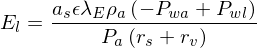

eq_Hl_MU
eq_Hl_MU = type('eq_Hl_MU', (Equation,), {'__doc__': '', 'expr': Eq(H_l, a_sh*c_pa*rho_a*(-T_a + T_l)/r_a)})


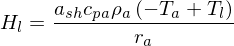

In [65]:
define_equation('eq_El_MU', Eq(E_l, a_s*lambda_E*rho_a*epsilon/(P_a*(r_v + r_s)) * (P_wl - P_wa)))
display(eq_El_MU)
define_equation('eq_Hl_MU', Eq(H_l, a_sh*rho_a*c_pa/r_a*(T_l - T_a)))
display(eq_Hl_MU)

Comparison of Eq. {eq_El_MU} with Eq. {eq_Elmol} (after substitution of Eqs. {eq_Cwl} and {eq_Cwa} and insertion into Eq. {eq_El}), assuming isothermal conditions (Tl=Ta ) and substituting Eq. {eq_epsilon} reveals that

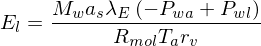

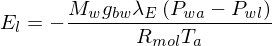

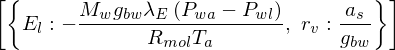

eq_rv_gbw
eq_rv_gbw = type('eq_rv_gbw', (Equation,), {'__doc__': '', 'expr': Eq(r_v, a_s/g_bw)})


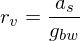

In [66]:
eq1 = eq_El_MU.subs(r_s, 0).subs(epsilon,eq_epsilon.rhs)
display(eq1)
eq2 =eq_El.subs(E_lmol,eq_Elmol.rhs).subs({C_wl:eq_Cwl.rhs, C_wa:eq_Cwa.rhs}).subs({T_l:T_a, g_tw:g_bw}).simplify()
display(eq2)
soln = solve([eq1, eq2], r_v, E_l, dict=True)
display(soln)
define_equation('eq_rv_gbw', Eq(r_v, soln[0][r_v]))
display(eq_rv_gbw)

<p><span style="color: #ff0000;">Note that according to eq_El_MU, $r_v$ is one-sided resistance, while according to eq_Elmol, $g_{bw}$ is total conductance. Therefore, for hypostomatous leaves, they are both one-sided, whereas for amphistomatous leaves, the one -sided resistance is twice $1/g_{bw}$.</span></p>

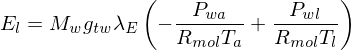

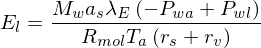

In [67]:
display(eq_El.subs(dict_eq(eq_Elmol)).subs(dict_eq(eq_Cwl, eq_Cwa)))
display(eq_El_MU.subs(dict_eq(eq_epsilon)))

In [68]:
from sympy import oo
eq_gtw.subs(g_bw, oo)

Setting r_v to 0 is equivalent to setting g_bw to infinity, i.e. g_tw = g_sw. Below, we do both to get r_s as a function of g_sw:

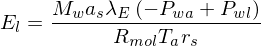

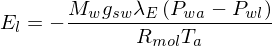

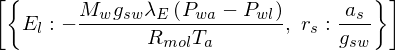

eq_rs_gsw
eq_rs_gsw = type('eq_rs_gsw', (Equation,), {'__doc__': '', 'expr': Eq(r_s, a_s/g_sw)})


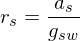

In [69]:
eq1 = eq_El_MU.subs(r_v, 0).subs(epsilon,eq_epsilon.rhs)
display(eq1)
eq2 = eq_El.subs(E_lmol,eq_Elmol.rhs).subs(
    {C_wl:eq_Cwl.rhs, C_wa:eq_Cwa.rhs}).subs(
    {T_l:T_a, g_tw:g_sw}).simplify()
display(eq2)
soln = solve([eq1, eq2], r_s, E_l, dict=True)
display(soln)
define_equation('eq_rs_gsw', Eq(r_s, soln[0][r_s].subs({T_l: T_a, g_tw: g_sw}).subs(dict_eq(eq_epsilon))))
display(eq_rs_gsw)

eq_ra_hc
eq_ra_hc = type('eq_ra_hc', (Equation,), {'__doc__': '', 'expr': Eq(r_a, c_pa*rho_a/h_c)})


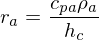

In [70]:
soln = solve([eq_Hl_MU.rhs - eq_Hl.rhs], r_a)
define_equation('eq_ra_hc', Eq(r_a, soln[r_a]))
display(eq_ra_hc)

## Generalisation of Penman's analytical approach
The key point of Penman's analytical solution is to formulate $E_l$ as a function of ($P_{wl} - P_{wa}$) and $H_l$ as a function of ($T_l - T_a$). We will do this by introducing general transfer coefficients for latent heat ($c_E$, W~m$^{-2}$~Pa$^{1}$) and sensible heat ($c_H$, W~m$^{-2}$~K$^{1}$):
##### {eq_El_cE}
\begin{equation}
E_l = c_E (P_{wl} - P_{wa})
\end{equation}
##### {eq_Hl_cH}
\begin{equation}
H_l = c_H (T_l - T_a)
\end{equation}
We now define the psychrometric constant as
##### {eq_gammav_cE}
\begin{equation}
\gamma_v = c_H/c_E
\end{equation}
and introduce it into Eq. {eq_Hl_cH} to obtain:
##### {eq_Hl_gammav}
\begin{equation}
H_l = \gamma_v c_E (T_l - T_a)
\end{equation}
Introduction of the Penman assumption (Eq. {eq_Penman_ass}) allows elimination of leaf temperature:
##### {eq_Hl_Pwl}
\begin{equation}
H_l = \frac{c_E \gamma_v (P_{wl} - P_{was})}{\Delta_{eTa}}
\end{equation}
Eqs. {eq_El_cE}, {eq_Hl_Pwl} and the leaf energy balance equation (Eq. {eq_Rs_enbal}), form a system of three equations that can be solved for $E_l$, $H_l$ and $P_{wl}$ to yield:
##### {eq_El_Delta}
\begin{equation}
E_{l} = \frac{\Delta_{eTa} c_E
{\left({R_{s}} - R_{ll}\right) + c_E c_{H} \left({P_{was}} - {P_{wa}}\right) }
}
{\Delta_{eTa} c_E + c_H}
\end{equation} 
and
##### {eq_Hl_Delta}
\begin{equation}
H_{l} = \frac{
c_H \left(R_s - R_{ll} \right) + c_E c_H \left(P_{wa} - P_{was}\right)
} 
{\Delta_{eTa} c_E + c_H}
\end{equation} 
In the above, we already substituted Eq. {eq_gammav_cE} to avoid confusion about the meaning of $\gamma_v$, which is often referred to as the psychrometric constant, but in this case, it would strongly depend on stomatal resistance and hence should not be referred to as a constant. 

Eqs. {eq_Hl_Delta} and {eq_Hl_cH} can now be used to get an analytical solution for leaf temperature ($T_l$):
##### {eq_Tl_Delta}
\begin{equation}
T_{l} = T_a + \frac{
(R_s - R_{ll}) +  c_{E} ({P_{wa}} - P_{was}) 
}
{\Delta_{eTa} c_E + c_H}
\end{equation}
Instead of using Eqs. {eq_Hl_Delta} and {eq_El_Delta} directly, one might obtain alternative analytic solutions for $H_l$ and $E_l$ by inserting Eq. {eq_Tl_Delta} into Eq. {eq_Hl_cH} or into Eq. {eq_Pwl} and the latter into the aerdynamic formulation given in Eq. {eq_El_cE}. 

In the original formulations by Penman and Monteith, the term $R_s - R_{ll}$ is referred to as net available energy and for a ground surface it is represented by net radiation minus ground heat flux ($R_N - G$). For a leaf, there is no ground heat flux, and $R_N = R_s - R_{ll}$. In most applications of the analytical solutions, $R_{ll}$ is not explicitly calculated, but it is assumed that $R_N$ is known, neglecting the dependence of $R_{ll}$ on the leaf temperature. Use of Eq. {eq_Tl_Delta} to estimate steady-state leaf temperature and subsequent calculation of $H_l$ and $E_l$ as outlined above, has the advantage that missing information on $R_{ll}$ would not directly affect calculation of $H_l$ and $E_l$, but only through its effect on leaf temperature. In fact, using $T_l$ obtained from Eq. {eq_Tl_Delta} by assuming that $R_{ll} = 0$ would then enable approximate estimation of the true $R_{ll}$ by inserting $T_l$ into Eq. {eq_Rll}.

In [71]:
var2('c_E', 'Latent heat transfer coefficient', units=joule/second/meter**2/pascal)
var2('c_H', 'Sensible heat transfer coefficient', units=joule/second/meter**2/kelvin)

In [72]:
define_equation('eq_El_cE', Eq(E_l, c_E*(P_wl - P_wa)))
display(eq_El_cE)
define_equation('eq_Hl_cH', Eq(H_l, c_H*(T_l - T_a)))
display(eq_Hl_cH)

eq_El_cE
eq_El_cE = type('eq_El_cE', (Equation,), {'__doc__': '', 'expr': Eq(E_l, c_E*(-P_wa + P_wl))})


eq_Hl_cH
eq_Hl_cH = type('eq_Hl_cH', (Equation,), {'__doc__': '', 'expr': Eq(H_l, c_H*(-T_a + T_l))})


eq_gammav_cE
eq_gammav_cE = type('eq_gammav_cE', (Equation,), {'__doc__': '', 'expr': Eq(gamma_v, c_H/c_E)})


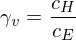

eq_Hl_gammav
eq_Hl_gammav = type('eq_Hl_gammav', (Equation,), {'__doc__': '', 'expr': Eq(H_l, c_E*gamma_v*(-T_a + T_l))})


In [73]:
# Introducing gamma_v = c_H/c_E into H_l
define_equation('eq_gammav_cE', Eq(gamma_v, c_H/c_E))
display(eq_gammav_cE)
define_equation('eq_Hl_gammav', Eq(H_l, c_E*gamma_v*(T_l - T_a)))
display(eq_Hl_gammav)

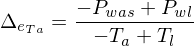

eq_Hl_Pwl
eq_Hl_Pwl = type('eq_Hl_Pwl', (Equation,), {'__doc__': '', 'expr': Eq(H_l, -c_E*gamma_v*(P_was - P_wl)/Delta_eTa)})


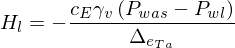

In [74]:
# Introducing the Penman-assumption to eliminate T_l
display(eq_Penman_ass)
soln = solve([eq_Hl_gammav, eq_Penman_ass], T_l, H_l)
define_equation('eq_Hl_Pwl', Eq(H_l, soln[H_l]))
display(eq_Hl_Pwl)

eq_El_Delta
eq_El_Delta
eq_El_Delta = type('eq_El_Delta', (Equation,), {'__doc__': '', 'expr': Eq(E_l, (-Delta_eTa*(R_ll - R_s) - P_wa*c_H + P_was*c_H)/(Delta_eTa + c_H/c_E))})


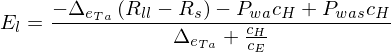

eq_Hl_Delta
eq_Hl_Delta
eq_Hl_Delta = type('eq_Hl_Delta', (Equation,), {'__doc__': '', 'expr': Eq(H_l, c_H*(P_wa*c_E - P_was*c_E - R_ll + R_s)/(c_E*(Delta_eTa + c_H/c_E)))})


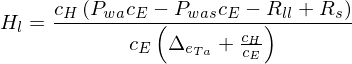

eq_Pwl_Delta
eq_Pwl_Delta
eq_Pwl_Delta = type('eq_Pwl_Delta', (Equation,), {'__doc__': '', 'expr': Eq(P_wl, (Delta_eTa*P_wa*c_E - Delta_eTa*(R_ll - R_s) + P_was*c_H)/(c_E*(Delta_eTa + c_H/c_E)))})


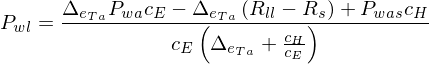

In [75]:
# Using energy balance to eliminate P_wl and eliminating gamma_v again
soln = solve([eq_Hl_Pwl,eq_El_cE, eq_Rs_enbal], E_l, H_l, P_wl)
for var in soln.keys():
    name = 'eq_' + str(var).replace('_','') + '_Delta'
    print(name)
    define_equation(name, Eq(var, soln[var].subs({gamma_v: eq_gammav_cE.rhs})))
    display(eval(name))

eq_Tl_Delta
eq_Tl_Delta = type('eq_Tl_Delta', (Equation,), {'__doc__': '', 'expr': Eq(T_l, (-R_ll + R_s + T_a*c_H + c_E*(Delta_eTa*T_a + P_wa - P_was))/(Delta_eTa*c_E + c_H))})


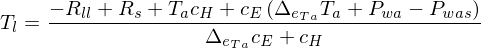

In [76]:
# Solving for T_l
soln = solve([eq_Hl_Delta, eq_Hl_cH], H_l, T_l)
define_equation('eq_Tl_Delta', Eq(T_l, soln[T_l].expand().factor(c_E)))
display(eq_Tl_Delta)

eq_Tl_Delta1
eq_Tl_Delta1 = type('eq_Tl_Delta1', (Equation,), {'__doc__': '', 'expr': Eq(T_l, T_a + (-R_ll + R_s + c_E*(P_wa - P_was))/(Delta_eTa*c_E + c_H))})


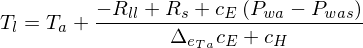

In [77]:
# Test if formulation in paper is the same
from sympy import simplify
define_equation('eq_Tl_Delta1', Eq(T_l, T_a + ((R_s - R_ll) + c_E*(P_wa - P_was))/(Delta_eTa*c_E + c_H)))
display(eq_Tl_Delta1)
simplify(eq_Tl_Delta.rhs - eq_Tl_Delta1.rhs)

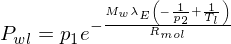

eq_Twl_Delta2
eq_Twl_Delta2 = type('eq_Twl_Delta2', (Equation,), {'__doc__': '', 'expr': Eq(T_l, M_w*lambda_E/(R_mol*log(p_CC1*(Delta_eTa*c_E + c_H)*exp(M_w*lambda_E/(R_mol*p_CC2))/(Delta_eTa*P_wa*c_E - Delta_eTa*R_ll + Delta_eTa*R_s + P_was*c_H))))})


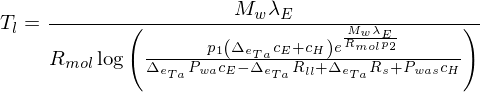

In [78]:
# Alternative approach to get T_l
display(eq_Pwl)
soln = solve([eq_Pwl_Delta, eq_Pwl], T_l, P_wl, dict=True)
define_equation('eq_Twl_Delta2', Eq(T_l, simplify(soln[0][T_l])))
display(eq_Twl_Delta2)

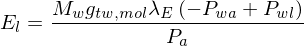

In [79]:
eq_El.subs({E_lmol: eq_Elmol_conv.rhs})

In [80]:
eq_Hl

eq_ce_conv
eq_ce_conv = type('eq_ce_conv', (Equation,), {'__doc__': '', 'expr': Eq(c_E, M_w*g_twmol*lambda_E/P_a)})


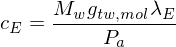

eq_ch_hc
eq_ch_hc = type('eq_ch_hc', (Equation,), {'__doc__': '', 'expr': Eq(c_H, a_sh*h_c)})


In [81]:
eqEl = eq_El.subs({E_lmol: eq_Elmol_conv.rhs})
eqHl = eq_Hl
soln = solve([eqEl, eq_El_cE], c_E, E_l)
define_equation('eq_ce_conv', Eq(c_E, soln[c_E]))
display(eq_ce_conv)

soln = solve([eqHl, eq_Hl_cH], c_H, H_l)
define_equation('eq_ch_hc', Eq(c_H, soln[c_H]))
display(eq_ch_hc)

In [82]:
def replace_variables(expr, variables=None):
    """Replace all base variables in expression by ``variables``, 
    which can contain a dictionary of variables or a set of
    equations."""
    from sympy.core.expr import Expr
    from essm.variables.utils import extract_variables
    from essm.equations._core import BaseEquation

    if not isinstance(expr, Expr):  # stop recursion
        return expr
    symbols = {
        key: getattr(key, '_name', key)
        for key in extract_variables(expr)
    }
    if isinstance(variables, set):
        variables = {
            eq.lhs: replace_variables(eq.rhs) for eq in variables
        }
    else:
        variables = {
            getattr(key, '_name', key): replace_variables(value)
            for key, value in (variables or {}).items()
    }
    if isinstance(expr, BaseEquation):
        return Eq(
            expr.lhs.xreplace(symbols).xreplace(variables),
            expr.rhs.xreplace(symbols).xreplace(variables)
        )
    return expr.xreplace(symbols).xreplace(variables)

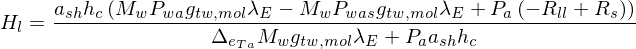

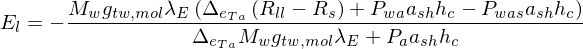

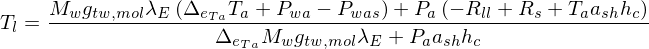

In [83]:
display(simplify(replace_variables(eq_Hl_Delta, {eq_ce_conv, eq_ch_hc})))
display(simplify(replace_variables(eq_El_Delta, {eq_ce_conv, eq_ch_hc})))
display(simplify(replace_variables(eq_Tl_Delta, {eq_ce_conv, eq_ch_hc})))

We can actually do this in one step:

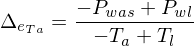

SOLUTION:


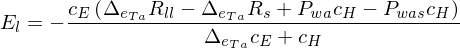

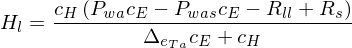

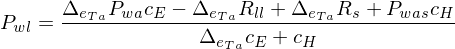

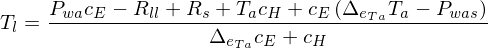

In [84]:
eqs = [eq_El_cE, eq_Hl_cH, eq_Rs_enbal, eq_Penman_ass]
for eq in eqs: display(eq)
soln = solve([eq_Hl_cH, eq_Penman_ass, eq_El_cE, eq_Rs_enbal], E_l, H_l, P_wl, T_l)
print('SOLUTION:')
for item in soln.items(): 
    display(Eq(item[0], item[1]))

## Comparison with explicit leaf energy balance model
To test the above equations, we will compare results with the explicit leaf energy balance equations from essmequations.leaf.energy_water.

In [85]:
from sympy import nsolve
def fun_SS(vdict1):
    '''
    Steady-state T_l, R_ll, H_l and E_l under forced conditions.
    Parameters are given in a dictionary (vdict) with the following entries:
    a_s, a_sh, L_l, P_a, P_wa, R_s, Re_c, T_a, g_sw, v_w
    ''' 
   
    vdict = vdict1.copy()

    # Nusselt number
    vdict[nu_a] = eq_nua.rhs.subs(vdict)
    vdict[Re] = eq_Re.rhs.subs(vdict)
    vdict[Nu] = eq_Nu_forced_all.rhs.subs(vdict)
    
    # h_c
    vdict[k_a] = eq_ka.rhs.subs(vdict)
    vdict[h_c] = eq_hc.rhs.subs(vdict)
 
    # gbw
    vdict[D_va] = eq_Dva.rhs.subs(vdict)
    vdict[alpha_a] = eq_alphaa.rhs.subs(vdict)
    vdict[rho_a] =  eq_rhoa.rhs.subs(vdict)
    vdict[Le] =  eq_Le.rhs.subs(vdict)
    vdict[g_bw] = eq_gbw_hc.rhs.subs(vdict)   
    
    # Hl, Rll
    vdict[R_ll] = eq_Rll.rhs.subs(vdict)
    vdict[H_l] = eq_Hl.rhs.subs(vdict)   

    # El
    vdict[g_tw] =  eq_gtw.rhs.subs(vdict)
    vdict[C_wa] = eq_Cwl.rhs.subs({P_wl: P_wa, T_l: T_a}).subs(vdict)
    vdict[P_wl] = eq_Pwl.rhs.subs(vdict)
    vdict[C_wl] = eq_Cwl.rhs.subs(vdict)
    vdict[E_lmol] = eq_Elmol.rhs.subs(vdict)
    vdict[E_l] = eq_El.rhs.subs(vdict)

    # Tl
    expr1 = (eq_Rs_enbal.rhs - R_s).subs(vdict)
    try:
        Tlss = nsolve(expr1, T_l, (273, 373))
    except Exception as e1: 
        print(e1)
        print(eq_Rs_enbal.rhs - R_s).subs(vdict)
        print('too many unknowns for finding T_l: ' + str((eq_Rs_enbal - R_s).subs(vdict)))
    
    # Re-inserting T_l
    vdict[T_l] = Tlss
    resdict = vdict.copy()
    for key in vdict.keys():
        try:
            resdict[key] = vdict[key].subs({T_l: vdict[T_l]})
        except:
            resdict[key] = vdict[key]

    
    # Test for steady state
    relative_deviation = (eq_Rs_enbal.rhs - R_s).subs(resdict) /\
        max(resdict[E_l], resdict[R_s], resdict[H_l], resdict[R_ll])
    if relative_deviation > 1e-6:
        return 'error in energy balance: El + Hl + Rll - R_s = ' + str(n((E_l + H_l + R_ll - R_s).subs(vdict))) 
    return resdict

In [86]:
# Test
vdict = cdict.copy()
#vdict= {}
vdict[a_s] = 1.0    # one sided stomata
vdict[g_sw] = 0.01    
vdict[T_a] = 273 + 25.5
vdict[T_w] = vdict[T_a] # Wall temperature equal to air temperature
vdict[P_a] = 101325
rha = 1
vdict[P_wa] = rha*eq_Pwl.rhs.subs(T_l, T_a).subs(vdict)
vdict[L_l] = 0.03
vdict[Re_c] = 3000
vdict[R_s] = 600
vdict[v_w] = 1
str1 = ''
for key1 in vdict.keys():
    str1 = str1+'$'+ latex(key1)+'$ '

#vdict = dict(vdict.items()+cdict.items())
str1 = ''
for key1 in vdict.keys():
    str1 = str1+'$'+ latex(key1)+'$ '

resdict = fun_SS(vdict)
for name1 in [T_l, E_l, H_l, R_ll]:
    print(str(name1)+' = ' + str(resdict[name1]*name1.definition.unit))
    
    
vdict[P_was] = eq_Pwl.rhs.subs(T_l, T_a).subs(vdict) 
vdict[Delta_eTa] = eq_Deltaeta_T.rhs.subs(vdict)
vdict[k_a] = eq_ka.rhs.subs(vdict)
vdict[nu_a] = eq_nua.rhs.subs(vdict)
vdict[Re] = eq_Re.rhs.subs(vdict)
vdict[Nu] = eq_Nu_forced_all.rhs.subs(vdict)
vdict[h_c] = eq_hc.rhs.subs(vdict) 

vdict[P_N2] = eq_PN2.rhs.subs(vdict)
vdict[P_O2] = eq_PO2.rhs.subs(vdict)
vdict[alpha_a] = eq_alphaa.rhs.subs(vdict)
vdict[k_a] = eq_ka.rhs.subs(vdict)
vdict[D_va] = eq_Dva.rhs.subs(vdict)
vdict[Le] = eq_Le.rhs.subs(vdict)
vdict[rho_a] = eq_rhoa_Pwa_Ta.rhs.subs(vdict) 
vdict[g_bw] = eq_gbw_hc.rhs.subs(vdict)
vdict[g_tw] = eq_gtw.rhs.subs(vdict)
vdict[g_twmol] = eq_gtwmol_gtw.rhs.subs(vdict).subs(resdict)

vdict[R_ll] = 0
print('\nDIRECT ESTIMATES: ')
resdict1 = {}
resdict1[R_ll] = vdict[R_ll]
resdict1[E_l] = replace_variables(eq_El_Delta.rhs, dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
resdict1[H_l] = replace_variables(eq_Hl_Delta.rhs, dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
resdict1[T_l] = replace_variables(eq_Tl_Delta.rhs, dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
resdict1[P_wl] = replace_variables(eq_Pwl_Delta.rhs, dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
for name1 in [T_l, E_l, H_l, R_ll, P_wl]:
    print(str(name1)+' = ' + str(resdict1[name1]*name1.definition.unit))
print('Energy balance: ' + str(vdict[R_s]) + '==' + str((E_l + H_l + R_ll).subs(resdict1).subs(vdict)))
    
print('\nUSING ESTIMATED T_l: ')
vdict[T_l] = eq_Tl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
vdict[P_wl] = eq_Pwl.rhs.subs(vdict)
resdict1 = {}
resdict1[T_l] = vdict[T_l]
resdict1[P_wl] = vdict[P_wl]
resdict1[E_l] = replace_variables(eq_El.rhs, dict_eq(eq_Elmol_conv)).subs(vdict)
resdict1[H_l] = eq_Hl.rhs.subs(vdict)
resdict1[R_ll] = eq_Rll.rhs.subs(vdict)
for name1 in [T_l, E_l, H_l, R_ll, P_wl]:
    print(str(name1)+' = ' + str(resdict1[name1]*name1.definition.unit))
print('Energy balance: ' + str(vdict[R_s]) + '==' + str((E_l + H_l + R_ll).subs(resdict1).subs(vdict)))

print('\nUSING ESTIMATED T_l ONLY TO RECALCULATE R_ll: ')
vdict[R_ll] = eq_Rll.rhs.subs(vdict)
resdict1 = {}
resdict1[R_ll] = vdict[R_ll]
resdict1[E_l] = replace_variables(eq_El_Delta.rhs, dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
resdict1[H_l] = replace_variables(eq_Hl_Delta.rhs, dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
resdict1[T_l] = replace_variables(eq_Tl_Delta.rhs, dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
resdict1[P_wl] = replace_variables(eq_Pwl_Delta.rhs, dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
for name1 in [T_l, E_l, H_l, R_ll, P_wl]:
    print(str(name1)+' = ' + str(resdict1[name1]*name1.definition.unit))
print('Energy balance: ' + str(vdict[R_s]) + '==' + str((E_l + H_l + R_ll).subs(resdict1).subs(vdict)))

print('\nUSING 1 ITERATION to get T_l: ')
vdict[R_ll] = 0
vdict[T_l] = eq_Tl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
print('T_l(R_ll=0): ' + str(vdict[T_l]))
vdict[R_ll] = eq_Rll.rhs.subs(vdict)
print('R_ll(T_l) = ' + str(vdict[R_ll]))
vdict[T_l] = eq_Tl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
vdict[P_wl] = eq_Pwl.rhs.subs(vdict)
resdict1 = {}
resdict1[T_l] = vdict[T_l]
resdict1[P_wl] = vdict[P_wl]
resdict1[E_l] = replace_variables(eq_El.rhs, dict_eq(eq_Elmol_conv)).subs(vdict)
resdict1[H_l] = eq_Hl.rhs.subs(vdict)
resdict1[R_ll] = eq_Rll.rhs.subs(vdict)
for name1 in [T_l, E_l, H_l, R_ll, P_wl]:
    print(str(name1)+' = ' + str(resdict1[name1]*name1.definition.unit))
print('Energy balance: ' + str(vdict[R_s]) + '==' + str((E_l + H_l + R_ll).subs(resdict1).subs(vdict)))


T_l = 305.650648422736*K
E_l = 185.424519010311*J/(m**2*s)
H_l = 325.157459266009*J/(m**2*s)
R_ll = 89.4180217236781*W/m**2

DIRECT ESTIMATES: 
T_l = 307.470332707075*K
E_l = 192.097049194965*J/(m**2*s)
H_l = 407.902950805035*J/(m**2*s)
R_ll = 0
P_wl = 4928.00932489798*Pa
Energy balance: 600==600.000000000000

USING ESTIMATED T_l: 
T_l = 307.470332707075*K
E_l = 244.389791260473*J/(m**2*s)
H_l = 407.902950805037*J/(m**2*s)
R_ll = 113.198548064994*W/m**2
P_wl = 5394.9876857848*Pa
Energy balance: 600==765.491290130504

USING ESTIMATED T_l ONLY TO RECALCULATE R_ll: 
T_l = 305.777951643573*K
E_l = 155.855204100899*J/(m**2*s)
H_l = 330.946247834107*J/(m**2*s)
R_ll = 113.198548064994*W/m**2
P_wl = 4604.36675522092*Pa
Energy balance: 600==600.000000000000

USING 1 ITERATION to get T_l: 
T_l(R_ll=0): 307.470332707075
R_ll(T_l) = 113.198548064994
T_l = 305.777951643573*K
E_l = 189.377407198242*J/(m**2*s)
H_l = 330.946247834108*J/(m**2*s)
R_ll = 91.067929682185*W/m**2
P_wl = 4903.72270477319*Pa


In [87]:
# Isothermal conversion between gtw and gtwmol leads to quite a bit of error!
print( eq_El.rhs.subs(dict_eq(eq_Elmol_conv)).subs(dict_eq(eq_gtwmol_gtw_iso)).subs(resdict))
print( eq_El.rhs.subs(dict_eq(eq_Elmol_conv)).subs(dict_eq(eq_gtwmol_gtw)).subs(resdict))

199.120796183645
185.424519010311


<p><span style="color: #ff0000;">Isothermal conversion between gtw and gtwmol leads to quite a bit of error!<br /></span></p>

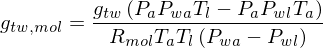

In [88]:
eq_gtwmol_gtw

In [89]:
vdict[P_wl]

In [90]:
# Test using eq_gtwmol_iso
vdict = cdict.copy()
#vdict= {}
vdict[a_s] = 1.0    # one sided stomata
vdict[g_sw] = 0.01    
vdict[T_a] = 273 + 25.5
vdict[T_w] = vdict[T_a] # Wall temperature equal to air temperature
vdict[P_a] = 101325
rha = 1
vdict[P_wa] = rha*eq_Pwl.rhs.subs(T_l, T_a).subs(vdict)
vdict[L_l] = 0.03
vdict[Re_c] = 3000
vdict[R_s] = 600
vdict[v_w] = 1

#vdict = dict(vdict.items()+cdict.items())

resdict = fun_SS(vdict)
for name1 in [T_l, E_l, H_l, R_ll]:
    print(str(name1)+' = ' + str(resdict[name1]))
vdict[P_was] = eq_Pwl.rhs.subs(T_l, T_a).subs(vdict) 
vdict[Delta_eTa] = eq_Deltaeta_T.rhs.subs(vdict)
vdict[k_a] = eq_ka.rhs.subs(vdict)
vdict[nu_a] = eq_nua.rhs.subs(vdict)
vdict[Re] = eq_Re.rhs.subs(vdict)
vdict[Nu] = eq_Nu_forced_all.rhs.subs(vdict)
vdict[h_c] = eq_hc.rhs.subs(vdict) 

vdict[P_N2] = eq_PN2.rhs.subs(vdict)
vdict[P_O2] = eq_PO2.rhs.subs(vdict)
vdict[alpha_a] = eq_alphaa.rhs.subs(vdict)
vdict[k_a] = eq_ka.rhs.subs(vdict)
vdict[D_va] = eq_Dva.rhs.subs(vdict)
vdict[Le] = eq_Le.rhs.subs(vdict)
vdict[rho_a] = eq_rhoa_Pwa_Ta.rhs.subs(vdict) 
vdict[g_bw] = eq_gbw_hc.rhs.subs(vdict)
vdict[g_tw] = eq_gtw.rhs.subs(vdict)
vdict[g_twmol] = eq_gtwmol_gtw_iso.rhs.subs(vdict)


vdict[R_ll] = 0
print('\nDIRECT ESTIMATES: ')
resdict1 = {}
resdict1[R_ll] = vdict[R_ll]
resdict1[E_l] = replace_variables(eq_El_Delta.rhs, dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
resdict1[H_l] = replace_variables(eq_Hl_Delta.rhs, dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
resdict1[T_l] = replace_variables(eq_Tl_Delta.rhs, dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
resdict1[P_wl] = replace_variables(eq_Pwl_Delta.rhs, dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
for name1 in [T_l, E_l, H_l, R_ll, P_wl]:
    print(str(name1)+' = ' + str(resdict1[name1]*name1.definition.unit))
print('Energy balance: ' + str(vdict[R_s]) + '==' + str((E_l + H_l + R_ll).subs(resdict1).subs(vdict)))
    
print('\nUSING ESTIMATED T_l: ')
vdict[T_l] = eq_Tl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
vdict[P_wl] = eq_Pwl.rhs.subs(vdict)
resdict1 = {}
resdict1[T_l] = vdict[T_l]
resdict1[P_wl] = vdict[P_wl]
resdict1[E_l] = replace_variables(eq_El.rhs, dict_eq(eq_Elmol_conv)).subs(vdict)
resdict1[H_l] = eq_Hl.rhs.subs(vdict)
resdict1[R_ll] = eq_Rll.rhs.subs(vdict)
for name1 in [T_l, E_l, H_l, R_ll, P_wl]:
    print(str(name1)+' = ' + str(resdict1[name1]*name1.definition.unit))
print('Energy balance: ' + str(vdict[R_s]) + '==' + str((E_l + H_l + R_ll).subs(resdict1).subs(vdict)))

print('\nUSING ESTIMATED T_l ONLY TO RECALCULATE R_ll: ')
vdict[R_ll] = eq_Rll.rhs.subs(vdict)
resdict1 = {}
resdict1[R_ll] = vdict[R_ll]
resdict1[E_l] = replace_variables(eq_El_Delta.rhs, dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
resdict1[H_l] = replace_variables(eq_Hl_Delta.rhs, dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
resdict1[T_l] = replace_variables(eq_Tl_Delta.rhs, dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
resdict1[P_wl] = replace_variables(eq_Pwl_Delta.rhs, dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
for name1 in [T_l, E_l, H_l, R_ll, P_wl]:
    print(str(name1)+' = ' + str(resdict1[name1]*name1.definition.unit))
print('Energy balance: ' + str(vdict[R_s]) + '==' + str((E_l + H_l + R_ll).subs(resdict1).subs(vdict)))

print('\nUSING 1 ITERATION to get T_l: ')
vdict[R_ll] = 0
vdict[T_l] = eq_Tl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
print('T_l(R_ll=0): ' + str(vdict[T_l]))
vdict[R_ll] = eq_Rll.rhs.subs(vdict)
print('R_ll(T_l) = ' + str(vdict[R_ll]))
vdict[T_l] = eq_Tl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
vdict[P_wl] = eq_Pwl.rhs.subs(vdict)
resdict1 = {}
resdict1[T_l] = vdict[T_l]
resdict1[P_wl] = vdict[P_wl]
resdict1[E_l] = replace_variables(eq_El.rhs, dict_eq(eq_Elmol_conv)).subs(vdict)
resdict1[H_l] = eq_Hl.rhs.subs(vdict)
resdict1[R_ll] = eq_Rll.rhs.subs(vdict)
for name1 in [T_l, E_l, H_l, R_ll, P_wl]:
    print(str(name1)+' = ' + str(resdict1[name1]*name1.definition.unit))
print('Energy balance: ' + str(vdict[R_s]) + '==' + str((E_l + H_l + R_ll).subs(resdict1).subs(vdict)))


T_l = 305.650648422736
E_l = 185.424519010311
H_l = 325.157459266009
R_ll = 89.4180217236781

DIRECT ESTIMATES: 
T_l = 307.263098002106*K
E_l = 201.520517691209*J/(m**2*s)
H_l = 398.479482308791*J/(m**2*s)
R_ll = 0
P_wl = 4888.37878666472*Pa
Energy balance: 600==600.000000000000

USING ESTIMATED T_l: 
T_l = 307.263098002106*K
E_l = 254.937149826832*J/(m**2*s)
H_l = 398.479482308791*J/(m**2*s)
R_ll = 110.468903558398*W/m**2
P_wl = 5332.58270455183*Pa
Energy balance: 600==763.885535694020

USING ESTIMATED T_l ONLY TO RECALCULATE R_ll: 
T_l = 305.649681621994*K
E_l = 164.417599968095*J/(m**2*s)
H_l = 325.113496473507*J/(m**2*s)
R_ll = 110.468903558398*W/m**2
P_wl = 4579.83703180819*Pa
Energy balance: 600==600.000000000000

USING 1 ITERATION to get T_l: 
T_l(R_ll=0): 307.263098002106
R_ll(T_l) = 110.468903558398
T_l = 305.649681621994*K
E_l = 199.088662380167*J/(m**2*s)
H_l = 325.113496473505*J/(m**2*s)
R_ll = 89.4054994288489*W/m**2
P_wl = 4868.15587829871*Pa
Energy balance: 600==613.6076

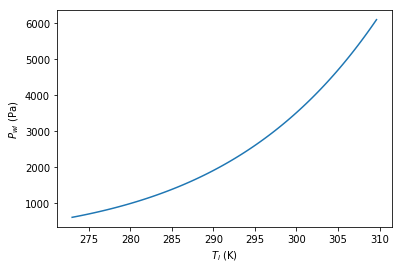

In [91]:
expr = eq_Pwl.rhs.subs(cdict)
display(expr)
plot_expr(expr, T_l, P_wl, 273, 310)

### Alternative approach, keeping $T_l$, but eliminateing $P_{wl}$

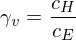

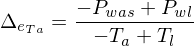

eq_El_gammav
eq_El_gammav = type('eq_El_gammav', (Equation,), {'__doc__': '', 'expr': Eq(E_l, -c_H*(P_wa - P_wl)/gamma_v)})


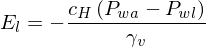

eq_El_Tl
eq_El_Tl = type('eq_El_Tl', (Equation,), {'__doc__': '', 'expr': Eq(E_l, c_H*(-Delta_eTa*T_a + Delta_eTa*T_l - P_wa + P_was)/gamma_v)})


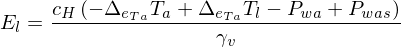

eq_El_Delta_a
eq_El_Delta_a
eq_El_Delta_a = type('eq_El_Delta_a', (Equation,), {'__doc__': '', 'expr': Eq(E_l, (-Delta_eTa*R_ll + Delta_eTa*R_s - P_wa*c_H + P_was*c_H)/(Delta_eTa + c_H/c_E))})


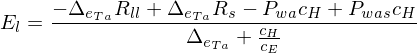

eq_Hl_Delta_a
eq_Hl_Delta_a
eq_Hl_Delta_a = type('eq_Hl_Delta_a', (Equation,), {'__doc__': '', 'expr': Eq(H_l, (P_wa*c_H - P_was*c_H - R_ll*c_H/c_E + R_s*c_H/c_E)/(Delta_eTa + c_H/c_E))})


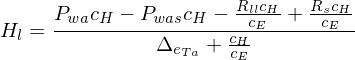

eq_Tl_Delta_a
eq_Tl_Delta_a
eq_Tl_Delta_a = type('eq_Tl_Delta_a', (Equation,), {'__doc__': '', 'expr': Eq(T_l, (Delta_eTa*T_a*c_H + P_wa*c_H - P_was*c_H + T_a*c_H**2/c_E - c_H*(R_ll - R_s)/c_E)/(c_H*(Delta_eTa + c_H/c_E)))})


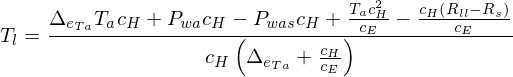

In [92]:
# Alternative approach, keeping T_l, but eliminateing P_wl
display(eq_El_cE)
display(eq_Hl_cH)
display(eq_gammav_cE)
display(eq_Penman_ass)
# Eliminating c_E
soln = solve([eq_El_cE, eq_gammav_cE], E_l, c_E)
define_equation('eq_El_gammav', Eq(E_l, soln[E_l]))
display(eq_El_gammav)

# Eliminating P_wl
soln = solve([eq_El_gammav, eq_Penman_ass], E_l, P_wl)
define_equation('eq_El_Tl', Eq(E_l, soln[E_l]))
display(eq_El_Tl)

# Solving for E_l, H_l and T_l
soln = solve([eq_El_Tl, eq_Hl_cH, eq_Rs_enbal], E_l, H_l, T_l)
for var in soln.keys():
    name = 'eq_' + str(var).replace('_','') + '_Delta_a'
    print(name)
    define_equation(name, Eq(var, soln[var].subs({gamma_v: eq_gammav_cE.rhs})))
    display(eval(name))

In [93]:
# These solutions are identical to the previous ones
print((eq_El_Delta - eq_El_Delta_a).simplify())
print((eq_Hl_Delta - eq_Hl_Delta_a).simplify())
print((eq_Tl_Delta1 - eq_Tl_Delta_a).simplify())

0
0
0


eq_El_Delta_b
eq_El_Delta_b
eq_El_Delta_b = type('eq_El_Delta_b', (Equation,), {'__doc__': '', 'expr': Eq(E_l, -c_E*(Delta_eTa*R_ll - Delta_eTa*R_s + P_wa*c_H - P_was*c_H)/(Delta_eTa*c_E + c_H))})


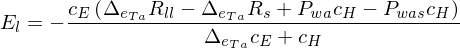

eq_Hl_Delta_b
eq_Hl_Delta_b
eq_Hl_Delta_b = type('eq_Hl_Delta_b', (Equation,), {'__doc__': '', 'expr': Eq(H_l, c_H*(P_wa*c_E - P_was*c_E - R_ll + R_s)/(Delta_eTa*c_E + c_H))})


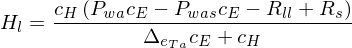

eq_Pwl_Delta_b
eq_Pwl_Delta_b
eq_Pwl_Delta_b = type('eq_Pwl_Delta_b', (Equation,), {'__doc__': '', 'expr': Eq(P_wl, (Delta_eTa*P_wa*c_E - Delta_eTa*R_ll + Delta_eTa*R_s + P_was*c_H)/(Delta_eTa*c_E + c_H))})


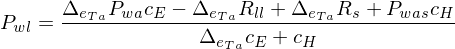

eq_Tl_Delta_b
eq_Tl_Delta_b
eq_Tl_Delta_b = type('eq_Tl_Delta_b', (Equation,), {'__doc__': '', 'expr': Eq(T_l, (P_wa*c_E - R_ll + R_s + T_a*c_H + c_E*(Delta_eTa*T_a - P_was))/(Delta_eTa*c_E + c_H))})


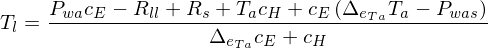

0
0
0


In [94]:
# More direct approach, not using gamma_v at all
soln = solve([eq_Hl_cH, eq_Penman_ass, eq_El_cE, eq_Rs_enbal], E_l, H_l, P_wl, T_l)
for var in soln.keys():
    name = 'eq_' + str(var).replace('_','') + '_Delta_b'
    print(name)
    define_equation(name, Eq(var, soln[var].subs({gamma_v: eq_gammav_cE.rhs})))
    display(eval(name))
print((eq_El_Delta - eq_El_Delta_b).simplify())
print((eq_Hl_Delta - eq_Hl_Delta_b).simplify())
print((eq_Tl_Delta1 - eq_Tl_Delta_b).simplify())

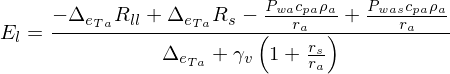

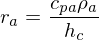

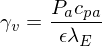

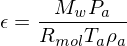

In [95]:
display(eq_El_PM2)
display(eq_ra_hc)
display(eq_gammav_MU)
display(eq_epsilon)

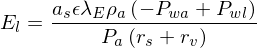

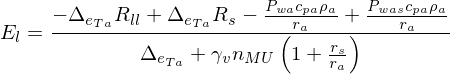

In [96]:
display(eq_El_MU)
display(eq_El_MU2)

In [97]:
eq_Hl_P52.free_symbols

In [98]:
eq_Tl_P52.free_symbols

In [99]:
# Fig. 8 in Ball et al. 1988
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.07
vdict[P_a] = 101325
vdict[P_wa] = 20/1000*101325
vdict[R_s] = 400
vdict[Re_c] = 3000
vdict[T_a] = 273+30
vdict[T_w] = vdict[T_a]
vdict[g_sw] = 0.15/40
vdict[v_w] = 1.

print('\nNUMERICAL SOLUTION: ')
resdict = fun_SS(vdict)
for name1 in [T_l, E_l, H_l, R_ll, g_bw, g_tw]:
    print( str(name1)+' = ' + str(resdict[name1]))

vdict[P_was] = eq_Pwl.rhs.subs(T_l, T_a).subs(vdict) 
vdict[Delta_eTa] = eq_Deltaeta_T.rhs.subs(vdict)
vdict[k_a] = eq_ka.rhs.subs(vdict)
vdict[nu_a] = eq_nua.rhs.subs(vdict)
vdict[Re] = eq_Re.rhs.subs(vdict)
vdict[Nu] = eq_Nu_forced_all.rhs.subs(vdict)
vdict[h_c] = eq_hc.rhs.subs(vdict) 

vdict[P_N2] = eq_PN2.rhs.subs(vdict)
vdict[P_O2] = eq_PO2.rhs.subs(vdict)
vdict[alpha_a] = eq_alphaa.rhs.subs(vdict)
vdict[k_a] = eq_ka.rhs.subs(vdict)
vdict[D_va] = eq_Dva.rhs.subs(vdict)
vdict[Le] = eq_Le.rhs.subs(vdict)
vdict[rho_a] = eq_rhoa_Pwa_Ta.rhs.subs(vdict) 
vdict[g_bw] = eq_gbw_hc.rhs.subs(vdict)
vdict[g_tw] = eq_gtw.rhs.subs(vdict)
vdict[g_twmol] = eq_gtwmol_gtw_iso.rhs.subs(vdict)

vdict[R_ll] = 0
print('\nDirect T_l estimates: ')
namesdict = [E_l, H_l]
vdict[E_l] = eq_El_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
vdict[H_l] = eq_Hl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
for name1 in namesdict:
    print(str(name1)+' = ' + str(vdict[name1]))
    
print(eq_Tl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict))
print(eq_Tl_Delta_a.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict))
print(eq_Tl_Delta_b.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict))
print(eq_Rs_enbal.subs(vdict))

print('\nUsing T_l from eq_Tl_Delta: ')
namesdict = [T_l, P_wl, E_l, H_l, R_ll]
vdict[T_l] = eq_Tl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
vdict[P_wl] = eq_Pwl.rhs.subs(vdict)
vdict[E_l] = eq_El.rhs.subs(dict_eq(eq_Elmol_conv)).subs(vdict)
vdict[H_l] = eq_Hl.rhs.subs(vdict)
vdict[R_ll] = eq_Rll.rhs.subs(vdict)
for name1 in namesdict:
    print(str(name1)+' = ' + str(vdict[name1]))
print(eq_Rs_enbal.subs(vdict))


print('\nUsing T_l from eq_Tl_Delta only to calculate R_ll: ')
namesdict = [T_l, R_ll, E_l, H_l]
vdict[R_ll] = 0
vdict[T_l] = eq_Tl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
vdict[R_ll] = eq_Rll.rhs.subs(vdict)
vdict[E_l] = eq_El_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
vdict[H_l] = eq_Hl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)

for name1 in namesdict:
    print(str(name1)+' = ' + str(vdict[name1]))
print(eq_Rs_enbal.subs(vdict))



print('Using T_l from eq_Tl_Delta_b: ')
namesdict = [T_l, P_wl, E_l, H_l, R_ll]
vdict[R_ll] = 0
vdict[T_l] = eq_Tl_Delta_b.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
vdict[P_wl] = eq_Pwl.rhs.subs(vdict)
vdict[E_l] = eq_El.rhs.subs(dict_eq(eq_Elmol_conv)).subs(vdict)
vdict[H_l] = eq_Hl.rhs.subs(vdict)
vdict[R_ll] = eq_Rll.rhs.subs(vdict)
for name1 in namesdict:
    print(str(name1)+' = ' + str(vdict[name1]))
print(eq_Rs_enbal.subs(vdict))

print('\nUsing T_l from eq_Tl_Delta_b only to calculate R_ll: ')
namesdict = [T_l, R_ll, E_l, H_l]
vdict[R_ll] = 0
vdict[T_l] = eq_Tl_Delta_b.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
vdict[R_ll] = eq_Rll.rhs.subs(vdict)
vdict[E_l] = eq_El_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
vdict[H_l] = eq_Hl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)

for name1 in namesdict:
    print(str(name1)+' = ' + str(vdict[name1]))
print(eq_Rs_enbal.subs(vdict))


NUMERICAL SOLUTION: 
T_l = 308.321395271278
E_l = 180.542235053941
H_l = 150.521099595469
R_ll = 68.9366653505872
g_bw = 0.0131620455576424
g_tw = 0.00291849206962754

Direct T_l estimates: 
E_l = 198.222104889661
H_l = 201.777895110339
310.133484539870
Eq(T_l, 310.13348453987)
Eq(T_l, 310.13348453987)
True

Using T_l from eq_Tl_Delta: 
T_l = 310.133484539870
P_wl = 6256.38161942359
E_l = 216.096641092879
H_l = 201.777895110338
R_ll = 93.2413750164809
False

Using T_l from eq_Tl_Delta only to calculate R_ll: 
T_l = 310.133484539870
R_ll = 93.2413750164809
E_l = 169.892070077828
H_l = 136.866554905691
False
Using T_l from eq_Tl_Delta_b: 
T_l = 310.133484539870
P_wl = 6256.38161942359
E_l = 216.096641092879
H_l = 201.777895110338
R_ll = 93.2413750164809
False

Using T_l from eq_Tl_Delta_b only to calculate R_ll: 
T_l = 310.133484539870
R_ll = 93.2413750164809
E_l = 169.892070077828
H_l = 136.866554905691
False


<p><span style="color: #ff0000;">Why does eq_Tl_Delta_b give a different result than eq_Tl_Delta? eq_Tl_Delta gives the appropriate $T_l$ to reproduce $H_l$ estimated using eq_Hl_Delta, whereas eq_Tl_Delta2 gives the <span style="color: #ff0000;">appropriate $T_l$ to reproduce $E_l$ estimated using eq_El_Delta. Neither allows for energy balance closure, unless only used to compute $R_{ll}$, before using eq_El_Delta and eq_Hl_Delta to compute the other components.</span><br /></span></p>

In [100]:
vdict[R_ll] = 0
eq_El_P52.rhs.subs(dict_eq(eq_S_gbw_gsw, eq_fu_gbw, eq_gammav_as)).subs(vdict)

## Inconsistencies in the PM equations
From the general form (Eq. {eq_El_Delta}), we can recover most of the above analytical solutions by appropriate substitutions for $c_E$ and $c_H$, but closer inspection of the necessary substitutions reveals some inconsistencies.

The Penman equation for a wet surface (Eq. {eq_Ew_P}) can be recovered by substituting $c_E = f_u$ and $c_H = \gamma_v f_u$ into (Eq. {eq_El_Delta}), while additional substitution of Eq. {eq_fu_ra_M} leads to recovery of Eq. {eq_Ew_PM1}, the Penman equation, as reformulated by \citet{monteith_evaporation_1965}. The formulation for leaf transpiration derived by \citet{penman_physical_1952} (Eq. {eq_El_P52}) is obtained by substituting $c_E = S f_u$ (deduced from Eq. {eq_El_fu_S}) and $c_E = \gamma_v f_u$ (from Eq. {eq_Hl_Tl_P52}). The substitutions are consistent with the formulations of latent and sensible heat flux given in Eqs. {eq_Hl_Tl_P52} and {eq_Ew_fu} or {eq_El_fu_S}, as long as $f_u$ and $r_a$ refer to the \emph{total resistances} of a leaf to latent and sensible heat flux respectively, as Eq. {eq_fu_ra_M} in conjunction with $c_H = \gamma_v f_u$ implies that:
##### {eq_cH_ra}
\begin{equation}
c_H = (\rho_a c_{pa})/r_a
\end{equation}


Similarly, the Penman-Monteith equation (Eq. {eq_El_PM2} with $\gamma_v$ defined in Eq. {eq_gammav_MU}) could be recovered by substituting $c_E = \epsilon \lambda_E \rho_a/(P_a(r_s + r_v))$ and $c_H = c_{pa} \rho_a/r_a$, with subsequent substitution of $r_v = r_a$.  Note however, that these substitutions are not consistent with Eqs. {eq_El_MU} and {eq_Hl_MU}, as the factors $a_s$ and $a_{sh}$ (referring to the number of leaf faces exchanging latent and sensible heat flux respectively) are missing. This is because the PM equation was derived with a soil surface in mind, which exchanges latent and sensible heat only on one side, and hence is not appropriate for a leaf. To alleviate this constraint, one could define $r_a$ and $r_s$ as total (two-sided) leaf resistances, but in this case, the simplification $r_v \approx r_a$ is not valid for hypostomatous leaves, as $r_a$ would then be only half of $r_v$. This is illustrated in Fig. {fig:leaf_BL-fluxes}, where sensible heat flux is released from both sides of the leaf, while latent heat flux is only released from the abaxial side, implying that $a_{sh}=2$ and $a_s=1$.

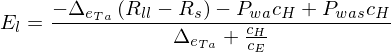

In [101]:
eq_El_Delta

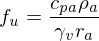

In [102]:
eq_fu_ra_M

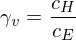

In [103]:
eq_gammav_cE

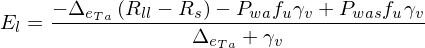

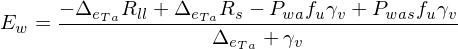

In [104]:
# This allows to recover eq_Ew_P
eq1 = eq_El_Delta.subs({c_E:f_u, c_H:gamma_v*f_u})
display(eq1.simplify())
display(eq_Ew_P)
(eq_Ew_P.rhs - eq1.rhs).simplify()

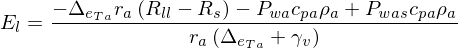

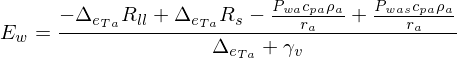

In [105]:
# This allows recovery of eq_Ew_PM1
eq1 = eq_El_Delta.subs({c_E: f_u, c_H: gamma_v*f_u}).subs(f_u, eq_fu_ra_M.rhs)
display(eq1.simplify())
display(eq_Ew_PM1)
(eq_Ew_PM1.rhs - eq1.rhs).simplify()

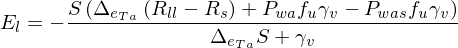

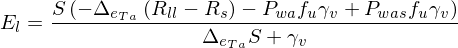

In [106]:
# This allows recovery of eq_El_P52
eq1 = eq_El_Delta.subs({c_E: f_u*S, c_H: gamma_v*f_u})
display(eq1.simplify())
display(eq_El_P52)
(eq_El_P52.rhs - eq1.rhs).simplify()

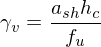

In [107]:
eq_gammav_hc_fu

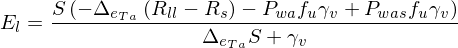

In [108]:
eq_El_P52

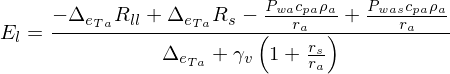

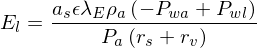

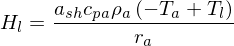

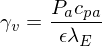

In [109]:
display(eq_El_PM2)
display(eq_El_MU)
display(eq_Hl_MU)
display(eq_gammav_MU)

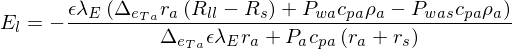

J/(m**2*s)


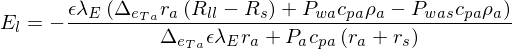

J/(m**2*s)


In [110]:
# This leads to recovery of eq_El_PM2
eq1 = eq_El_Delta.subs({c_E: epsilon*lambda_E*rho_a/(P_a*(r_s + r_v)),
                        c_H: c_pa*rho_a/r_a}).subs(r_v, r_a).simplify()
display(eq1)
print(derive_unit(eq1.rhs))
eq2 = eq_El_PM2.subs(gamma_v, eq_gammav_MU.rhs).simplify()
display(eq2)
print(derive_unit(eq2.rhs))
(eq1 - eq2).simplify()

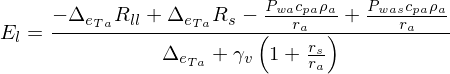

In [111]:
eq_El_PM2

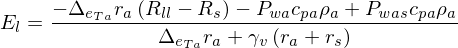

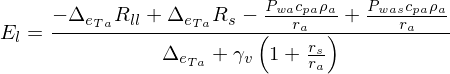

In [112]:
# Alternative recovery of eq_El_PM2, using gamma_v at the onset
eq1 = eq_El_Delta.subs({c_E: c_pa*rho_a/(gamma_v*(r_s + r_v)), 
                        c_H: c_pa*rho_a/r_a}).subs(r_v, r_a).simplify()
display(eq1)
eq2 = eq_El_PM2
display(eq2)
(eq1.rhs - eq2.rhs).simplify()

\citet{monteith_principles_2013} acknowledged that a hypostomatous leaf could exchange sensible heat on two sides, but latent heat on one side only and introduced the parameter $n_{MU} = a_{sh}/a_s$ to account for this (Eq. {eq_El_MU2}). Using our general equation, it should be possible to reproduce the MU-Equation (Eq. {eq_El_MU2}) by substituting 
$c_E = a_s \epsilon \lambda_E \rho_a/(P_a(r_s + r_v))$ (deduced from Eq. {eq_El_MU}) and $c_H = a_{sh} c_{pa} \rho_a/r_a$ (deduced from Eq. {eq_Hl_MU}) into Eq. {eq_El_Delta}. However, the result of this substitution, as presented in Eq. {eq_El_Delta_MUcorr}, is not the same as Eq. {eq_El_MU2} after substitution of Eqs. {eq_gammav_MU} and $n_{MU} = a_{sh}/a_s$, which would result in Eq. {eq_El_MU3}: 
##### {eq_El_Delta_MUcorr}
\begin{equation}
E_{l} = \frac{a_{s} \Delta_{eTa} \epsilon \lambda_{E} r_{a} \left(R_s - R_{ll}\right)
+ a_{s} {a_{sh}} {c_{pa}} \epsilon
\lambda_{E} \rho_{a} \left({P_{was}} - {P_{wa}}\right)}  
{P_{a} {a_{sh}} {c_{pa}} \left( r_{s} + r_a \right) + {\Delta_{eTa}} a_{s}
\epsilon \lambda_{E}}
\end{equation}
##### {eq_El_MU3}
\begin{equation}
E_{l} = \frac{a_{s} \Delta_{eTa} \epsilon \lambda_{E} r_{a} \left(R_s - R_{ll}\right)
+ a_{s} {c_{pa}} \epsilon
\lambda_{E} \rho_{a} \left({P_{was}} - {P_{wa}}\right)}  
{P_{a} {a_{sh}} {c_{pa}} \left( r_{s} + r_a \right) + {\Delta_{eTa}} a_{s}
\epsilon \lambda_{E}}
\end{equation}
Note the missing $a_{sh}$ in the nominator of Eq. {eq_El_MU3}. 
The reason is that \citet{monteith_principles_2013} introduced $n_{MU} = a_{sh}/a_s$ by modifying the meaning of $\gamma_v$ in Eq. {eq_Ew_PM1} and specifying that $r_a$, $r_v$ and $r_s$ respresent one-sided resitances. However, as explained above, $r_a$ in Eq. {eq_Ew_PM1} represents two-sided resistance to sensible heat flux (see Eq. {eq_cH_ra}). If we replace $r_a$ by $r_a = r_{a}/a_{sh} $ in Eq. {eq_Ew_PM1} before substitution of Eq. {eq_gammavs_MU}, we obtain a corrected MU-equation,
##### {eq_El_MU_corr}
\begin{equation}
E_l = \frac{\Delta_{eTa}(R_s - R_{ll}) + \rho_a c_{pa} (P_{was} - P_{wa})a_{sh}/r_a}
{\Delta_{eTa} + \gamma_v a_{sh}/a_s \left(1 + \frac{r_{s}}{r_a}\right)},
\end{equation}
which, after substitution of Eq. {eq_gammav_MU}, results in Eq. {eq_El_Delta_MUcorr}.

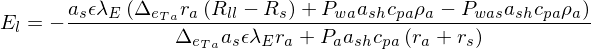

In [113]:
class eq_El_Delta_MUcorr(eq_El_Delta.definition):
    """Corrected MU-equation"""
    expr = (eq_El_Delta.subs({c_E: a_s*epsilon*lambda_E*rho_a / (P_a*(r_s + r_v)), 
                                       c_H: a_sh*c_pa*rho_a/r_a}).subs(r_v, r_a)).simplify()
eq_El_Delta_MUcorr

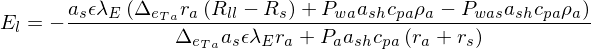

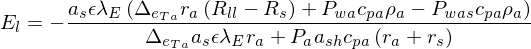

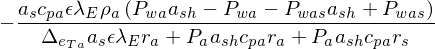

In [114]:
# This should lead to recovery of eq_El_MU2, but does not 
eq1 = eq_El_Delta_MUcorr
display(eq1)
eq2 = eq_El_MU2.subs(gamma_v, eq_gammav_MU.rhs).subs(n_MU, a_sh/a_s).simplify()
display(eq2)
(eq1.rhs - eq2.rhs).simplify()

If we replace $r_a$ by $r_a = r_{a}/a_{sh} $ in Eq. {eq_Ew_PM1} before substitution of Eq. {eq_gammavs_MU}, we obtain a corrected MU-equation,
##### {eq_El_MU_corr}
\begin{equation}
E_l = \frac{\Delta_{eTa}(R_s - R_{ll}) + \rho_a c_{pa} (P_{was} - P_{wa})a_{sh}/r_a}
{\Delta_{eTa} + \gamma_v a_{sh}/a_s \left(1 + \frac{r_{s}}{r_a}\right)},
\end{equation}
which, after substitution of Eq. {eq_gammav_MU}, results in Eq. {eq_El_Delta_MUcorr}.

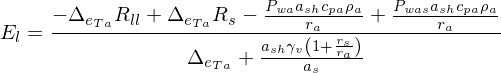

In [115]:
class eq_El_MU_corr(eq_Ew_PM1.definition, eq_gammavs_MU.definition):
    """Corrected MU-equation, equivalent to Eq. 22 in \citet{schymanski_leaf-scale_2018}"""
    expr = Eq(E_l, eq_Ew_PM1.rhs.subs(r_a, r_a/a_sh).subs(dict_eq(eq_gammavs_MU)).subs(n_MU, n_MU.definition.expr))
eq_El_MU_corr

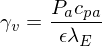

In [116]:
eq_gammav_MU

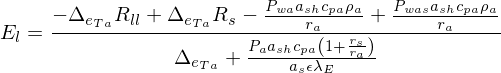

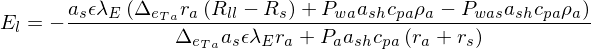

In [117]:
# Test that eq_El_MU_corr.subs(eq_gammav_MU) is the same as eq_El_Delta_MUcorr
eq1 = eq_El_MU_corr.subs(eq_gammav_MU)
display(eq1)
eq2 = eq_El_Delta_MUcorr
display(eq2)
(eq1.rhs - eq2.rhs).simplify()

<p><span style="color: #ff0000;">If we replace $r_a$ by $r_a/a_{sh}$ in eq_Ew_PM1, and only then insert eq_gammavs_MU, we get the right solution, equivalent to general equation with $c_E = a_s \epsilon \lambda_E \rho_a/(P_a (r_s + r_v))$ and $c_H = a_{sh} c_{pa} \rho_a/r_a)$, assuming  $r_v = r_a$<br /></span></p>

In [118]:
import matplotlib.pyplot as plt
from sympy import latex
from sympy import N
from numpy import arange
from essm.variables.units import derive_unit, SI, Quantity
from essm.variables.utils import markdown
import matplotlib.pyplot as plt
from sympy import latex
from sympy import N
from numpy import arange
from essm.variables.units import derive_unit, SI, Quantity
from essm.variables.utils import markdown
def plot_expr2(xvar_min_max, yldata, yllabel=None, yrdata=None,
               yrlabel='', clf=True, npoints=100):
    '''
    Plot expression as function for variable from xmin to xmax.
    Example:
    expr = eq_Pwa_CC.subs(Variable.__defaults__)
    exprr = Eq(n_g*R_mol*T_g, P_wa*V_g).subs({P_wa:1, V_g:2})
    xvar = T_g
    yldata = [(expr.rhs, 'full'), (expr.rhs/2, 'half')]
    yrdata = exprr
    plot_expr2((T_g, 273, 373), yldata, yllabel=(P_wa), yrdata=yrdata)
    '''
    (xvar, xmin, xmax) = xvar_min_max
    linestyles = ['-', '--', '-.', ':']
    if clf:
        plt.close
        plt.clf
    if hasattr(xvar, 'definition'): 
        xlabel = '$'+latex(xvar)+'$'+ ' (' + markdown(derive_unit(xvar)) + ')'
    else: 
        xlabel = xvar
    if hasattr(yldata, 'lhs'):
        yllabel = yldata.lhs
        yldata = yldata.rhs
    if type(yllabel) is not str: 
        yllabel = '$'+latex(yllabel)+'$'+ ' (' + markdown(derive_unit(yllabel)) + ')'     
    if type (yldata) is not list and type(yldata) is not tuple:
        # If only an expression given
        yldata = [(yldata, '')]
    if type(yldata[0]) is not tuple:
        yldata = [yldata]
    if yrdata is not None:
        if hasattr(yrdata, 'lhs'):
            yrlabel = yrdata.lhs
            yrdata = yrdata.rhs
        if type(yrlabel) is not str: 
            yrlabel = '$'+latex(yrlabel)+'$'+ ' (' + markdown(derive_unit(yrlabel)) + ')'     
        if type (yrdata) is not list and type(yrdata) is not tuple:
            # If only an expression given
            yrdata = [(yrdata, '')]
        if type(yrdata[0]) is not tuple:
            yrdata = [yrdata]    
    
    xstep = (xmax - xmin)/npoints
    xvals = arange(xmin, xmax, xstep)
       
    fig, ax1 = plt.subplots()
    color = 'black'
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(yllabel, color=color)
    i = 0
    for (expr1, y1var) in yldata:
        linestyle = linestyles[i]
        i= i + 1
        try: 
            y1vals = [expr1.subs(xvar, dummy).n() for dummy in xvals]                   
            ax1.plot(xvals, y1vals, color=color, linestyle=linestyle, label=y1var)
        except Exception as e1:
            print([expr1.subs(xvar, dummy) for dummy in xvals])
            print(e1)
        ax1.tick_params(axis='y', labelcolor=color)
    plt.legend()
    
    if yrdata is not None:      
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:blue'
        ax2.set_ylabel(yrlabel, color=color)
        i = 0
        
        for (expr2, y2var) in yrdata:
            linestyle = linestyles[i]
            i= i + 1
            try:
                y2vals = [expr2.subs(xvar, dummy).n() for dummy in xvals]
                ax2.plot(xvals, y2vals, color=color, linestyle=linestyle, label=y2var)
            except Exception as e1:
                print([expr2.subs(xvar, dummy).n() for dummy in xvals])
                print(e1)
            ax2.tick_params(axis='y', labelcolor=color)
            leg=ax2.legend(loc='lower right')
            ax2.add_artist(leg);

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

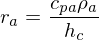

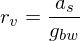

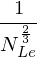

1.08204645272521


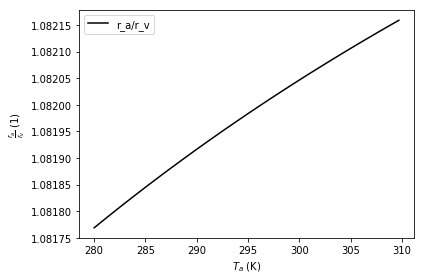

In [119]:
display(eq_ra_hc)
display(eq_rv_gbw)
display((eq_ra_hc.rhs/eq_rv_gbw.rhs).subs(g_bw, eq_gbw_hc.rhs))
plotfun = (eq_ra_hc.rhs/eq_rv_gbw.rhs).subs(g_bw, eq_gbw_hc.rhs
                                           ).subs(Le, eq_Le.rhs
                                                 ).subs({alpha_a:eq_alphaa.rhs, D_va:eq_Dva.rhs})
vdict = Variable.__defaults__.copy()

print(plotfun.subs(vdict).subs(T_a, 300))
P = plot_expr2((T_a, 280,310), (plotfun.subs(vdict), r_a/r_v), yllabel=r_a/r_v)
P

<p><span style="color: #ff0000;">$r_a/r_v$ is indeed  close to 1!</span></p> The ratio does not depend on a_s, as both refer to a one-sided leaf area.

In [120]:
print(r_a.__doc__)
print(r_v.__doc__)
print(g_bw.__doc__)

One-sided boundary layer resistance to heat transfer ($r_H$ in \citet[][P. 231]{monteith_principles_2013})
One-sided leaf BL resistance to water vapour, \citep[][Eqs. 11.3 and 13.16]{monteith_principles_2013}
Boundary layer conductance to water vapour.


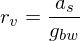

In [121]:
eq_rv_gbw

In [122]:
# Fig. 8 in Ball et al. 1988
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.07
vdict[P_a] = 101325
vdict[P_wa] = 20/1000*101325
vdict[R_s] = 400
vdict[Re_c] = 3000
vdict[T_a] = 273+30
vdict[T_w] = vdict[T_a]
vdict[g_sw] = 0.15/40
vdict[v_w] = 1.

print('\nNUMERICAL SOLUTION: ')
resdict = fun_SS(vdict)
for name1 in [T_l, E_l, H_l, R_ll, g_bw, g_tw]:
    print( str(name1)+' = ' + str(resdict[name1]))

vdict[P_was] = eq_Pwl.rhs.subs(T_l, T_a).subs(vdict) 
vdict[Delta_eTa] = eq_Deltaeta_T.rhs.subs(vdict)
vdict[k_a] = eq_ka.rhs.subs(vdict)
vdict[nu_a] = eq_nua.rhs.subs(vdict)
vdict[Re] = eq_Re.rhs.subs(vdict)
vdict[Nu] = eq_Nu_forced_all.rhs.subs(vdict)
vdict[h_c] = eq_hc.rhs.subs(vdict) 

vdict[P_N2] = eq_PN2.rhs.subs(vdict)
vdict[P_O2] = eq_PO2.rhs.subs(vdict)
vdict[alpha_a] = eq_alphaa.rhs.subs(vdict)
vdict[k_a] = eq_ka.rhs.subs(vdict)
vdict[D_va] = eq_Dva.rhs.subs(vdict)
vdict[Le] = eq_Le.rhs.subs(vdict)
vdict[rho_a] = eq_rhoa_Pwa_Ta.rhs.subs(vdict) 
vdict[g_bw] = eq_gbw_hc.rhs.subs(vdict)
vdict[g_tw] = eq_gtw.rhs.subs(vdict)
vdict[g_twmol] = eq_gtwmol_gtw_iso.rhs.subs(vdict)

vdict[R_ll] = 0
print('\nDirect T_l estimates: ')
namesdict = [E_l, H_l]
vdict[E_l] = eq_El_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
vdict[H_l] = eq_Hl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
for name1 in namesdict:
    print(str(name1)+' = ' + str(vdict[name1]))
    
print(eq_Tl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict))
print(eq_Tl_Delta_a.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict))
print(eq_Tl_Delta_b.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict))
print(eq_Rs_enbal.subs(vdict))

print('\nUsing T_l from eq_Tl_Delta: ')
namesdict = [T_l, P_wl, E_l, H_l, R_ll]
vdict[T_l] = eq_Tl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
vdict[P_wl] = eq_Pwl.rhs.subs(vdict)
vdict[E_l] = eq_El.rhs.subs(dict_eq(eq_Elmol_conv)).subs(vdict)
vdict[H_l] = eq_Hl.rhs.subs(vdict)
vdict[R_ll] = eq_Rll.rhs.subs(vdict)
for name1 in namesdict:
    print(str(name1)+' = ' + str(vdict[name1]))
print(eq_Rs_enbal.subs(vdict))


print('\nUsing T_l from eq_Tl_Delta only to calculate R_ll: ')
namesdict = [T_l, R_ll, E_l, H_l]
vdict[R_ll] = 0
vdict[T_l] = eq_Tl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
vdict[R_ll] = eq_Rll.rhs.subs(vdict)
vdict[E_l] = eq_El_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
vdict[H_l] = eq_Hl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)

for name1 in namesdict:
    print(str(name1)+' = ' + str(vdict[name1]))
print(eq_Rs_enbal.subs(vdict))



print('Using T_l from eq_Tl_Delta_b: ')
namesdict = [T_l, P_wl, E_l, H_l, R_ll]
vdict[R_ll] = 0
vdict[T_l] = eq_Tl_Delta_b.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
vdict[P_wl] = eq_Pwl.rhs.subs(vdict)
vdict[E_l] = eq_El.rhs.subs(dict_eq(eq_Elmol_conv)).subs(vdict)
vdict[H_l] = eq_Hl.rhs.subs(vdict)
vdict[R_ll] = eq_Rll.rhs.subs(vdict)
for name1 in namesdict:
    print(str(name1)+' = ' + str(vdict[name1]))
print(eq_Rs_enbal.subs(vdict))

print('\nUsing T_l from eq_Tl_Delta_b only to calculate R_ll: ')
namesdict = [T_l, R_ll, E_l, H_l]
vdict[R_ll] = 0
vdict[T_l] = eq_Tl_Delta_b.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
vdict[R_ll] = eq_Rll.rhs.subs(vdict)
vdict[E_l] = eq_El_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
vdict[H_l] = eq_Hl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)

for name1 in namesdict:
    print(str(name1)+' = ' + str(vdict[name1]))
print(eq_Rs_enbal.subs(vdict))


NUMERICAL SOLUTION: 
T_l = 308.321395271278
E_l = 180.542235053941
H_l = 150.521099595469
R_ll = 68.9366653505872
g_bw = 0.0131620455576424
g_tw = 0.00291849206962754

Direct T_l estimates: 
E_l = 198.222104889661
H_l = 201.777895110339
310.133484539870
Eq(T_l, 310.13348453987)
Eq(T_l, 310.13348453987)
True

Using T_l from eq_Tl_Delta: 
T_l = 310.133484539870
P_wl = 6256.38161942359
E_l = 216.096641092879
H_l = 201.777895110338
R_ll = 93.2413750164809
False

Using T_l from eq_Tl_Delta only to calculate R_ll: 
T_l = 310.133484539870
R_ll = 93.2413750164809
E_l = 169.892070077828
H_l = 136.866554905691
False
Using T_l from eq_Tl_Delta_b: 
T_l = 310.133484539870
P_wl = 6256.38161942359
E_l = 216.096641092879
H_l = 201.777895110338
R_ll = 93.2413750164809
False

Using T_l from eq_Tl_Delta_b only to calculate R_ll: 
T_l = 310.133484539870
R_ll = 93.2413750164809
E_l = 169.892070077828
H_l = 136.866554905691
False


In [123]:
# Fig. 8 in Ball et al. 1988
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.07
vdict[P_a] = 101325
vdict[P_wa] = 20/1000*101325
vdict[R_s] = 400
vdict[Re_c] = 3000
vdict[T_a] = 273+30
vdict[T_w] = vdict[T_a]
vdict[g_sw] = 0.15/40
vdict[v_w] = 1.

print('\nNUMERICAL SOLUTION: ')
resdict = fun_SS(vdict)
for name1 in [T_l, E_l, H_l, R_ll, g_bw, g_tw]:
    print( str(name1)+' = ' + str(resdict[name1]))

vdict[P_was] = eq_Pwl.rhs.subs(T_l, T_a).subs(vdict) 
vdict[Delta_eTa] = eq_Deltaeta_T.rhs.subs(vdict)
vdict[k_a] = eq_ka.rhs.subs(vdict)
vdict[nu_a] = eq_nua.rhs.subs(vdict)
vdict[Re] = eq_Re.rhs.subs(vdict)
vdict[Nu] = eq_Nu_forced_all.rhs.subs(vdict)
vdict[h_c] = eq_hc.rhs.subs(vdict) 

vdict[P_N2] = eq_PN2.rhs.subs(vdict)
vdict[P_O2] = eq_PO2.rhs.subs(vdict)
vdict[alpha_a] = eq_alphaa.rhs.subs(vdict)
vdict[k_a] = eq_ka.rhs.subs(vdict)
vdict[D_va] = eq_Dva.rhs.subs(vdict)
vdict[Le] = eq_Le.rhs.subs(vdict)
vdict[rho_a] = eq_rhoa_Pwa_Ta.rhs.subs(vdict) 
vdict[g_bw] = eq_gbw_hc.rhs.subs(vdict)
vdict[g_tw] = eq_gtw.rhs.subs(vdict)
vdict[g_twmol] = eq_gtwmol_gtw_iso.rhs.subs(vdict)

vdict[R_ll] = 0
print('\nDirect T_l estimates: ')
namesdict = [E_l, H_l]
vdict[E_l] = eq_El_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
vdict[H_l] = eq_Hl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
for name1 in namesdict:
    print(str(name1)+' = ' + str(vdict[name1]))
    
print(eq_Tl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict))
print(eq_Tl_Delta_a.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict))
print(eq_Tl_Delta_b.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict))
print(eq_Rs_enbal.subs(vdict))


print( 'Penman-stomata: ')
namesdict = [E_l, H_l, T_l]
vdict[S] = eq_S_gbw_gsw.rhs.subs(vdict)
vdict[f_u] = eq_fu_gbw.rhs.subs(vdict)
vdict[gamma_v] = eq_gammav_as.rhs.subs(vdict)
vdict[E_l] = eq_El_P52.rhs.subs(vdict)
vdict[H_l] = eq_Hl_P52.rhs.subs(vdict)
vdict[T_l] = eq_Tl_P52.rhs.subs(vdict)
for name1 in namesdict:
    print( str(name1)+' = ' + str(vdict[name1]))
    
print( eq_Rs_enbal.subs(vdict))

print( 'PM-equation: ')
namesdict = [E_l, H_l]
vdict[r_s] = 1/vdict[g_sw]
vdict[r_a] = eq_ra_hc.rhs.subs(vdict)
vdict[gamma_v] = eq_gammav_MU.rhs.subs(vdict)
vdict[epsilon] = eq_epsilon.rhs.subs(vdict)
vdict[E_l] = eq_El_PM2.rhs.subs(vdict)
vdict[H_l] = (R_s - R_ll - E_l).subs(vdict)

for name1 in namesdict:
    print( str(name1)+' = ' + str(vdict[name1]))
    
print( eq_Rs_enbal.subs(vdict))

print( 'MU-equation: ')
namesdict = [E_l, H_l]
vdict[n_MU] = (a_sh/a_s).subs(vdict)
vdict[E_l] = eq_El_MU2.rhs.subs(vdict)
vdict[H_l] = (R_s - R_ll - E_l).subs(vdict)

for name1 in namesdict:
    print( str(name1)+' = ' + str(vdict[name1]))
    
print( eq_Rs_enbal.subs(vdict))

print( 'Corrected MU-equation: ')
namesdict = [E_l, H_l]
vdict[E_l] = eq_El_MU_corr.rhs.subs(vdict)
vdict[H_l] = (R_s - R_ll - E_l).subs(vdict)

for name1 in namesdict:
    print( str(name1)+' = ' + str(vdict[name1]))
    
print( eq_Rs_enbal.subs(vdict))


NUMERICAL SOLUTION: 
T_l = 308.321395271278
E_l = 180.542235053941
H_l = 150.521099595469
R_ll = 68.9366653505872
g_bw = 0.0131620455576424
g_tw = 0.00291849206962754

Direct T_l estimates: 
E_l = 198.222104889661
H_l = 201.777895110339
310.133484539870
Eq(T_l, 310.13348453987)
Eq(T_l, 310.13348453987)
True
Penman-stomata: 
E_l = 198.222104889661
H_l = 201.777895110339
T_l = 310.133484539870
False
PM-equation: 
E_l = 127153.771059783/(241.645433101007 + 177.259588325958/epsilon)
H_l = 157.117500717726
True
MU-equation: 
E_l = 127153.771059783/(241.645433101007 + 354.519176651916/epsilon)
H_l = 242.122266846530
True
Corrected MU-equation: 
E_l = 157649.368879163/(241.645433101007 + 354.519176651916/epsilon)
H_l = 204.258066557731
True


<p><span style="color: #ff0000;">Penman-stomata gives identical results to the general solutions. </span></p>
<p><span style="color: #ff0000;">PM-equation greatly over-estimates $E_l$.</span></p>
<p><span style="color: #ff0000;">MU-equation greatly under-estimates $E_l$. </span></p>

## Analytical solution including longwave balance
The above analytical solutions eliminated the non-linearity problem of the saturation vapour pressure curve, but they did not take into account that the longwave component of the leaf energy balance ($R_{ll}$) also depends on leaf temperature, as expressed in Eq. {eq_Rll}. Therefore, the above analytical equations are commonly used in conjunction with fixed value of $R_{ll}$, either taken from observations or the assumption that $R_{ll}=0$. Here we will replace the non-linear Eq. {eq_Rll} by its tangent at $T_l = T_a$, which is given by:
##### {eq_Rll_tang}
\begin{equation}
R_{ll} = 4 a_{sh} \epsilon_l \sigma T_a^3 T_l - a_{sh} \epsilon_l \sigma (T_w^4 + 3 T_a^4)
\end{equation}
This introduces a bias of less than -20~W~m$^{-2}$ in the calculation of $R_{ll}$ for leaf temperatures $\pm 20$ K of air temperture, compared to Eq. {eq_Rll} (see Fig. {fig:Rll_lin}.



We can now use a similar procedure as in Section {sec:Penman_general}, but this time aimed at eliminating $P_{wl}$ using the Penman assumption, rather than eliminating $T_l$. We first eliminate $c_E$ from Eq. {eq_El_cE} by introducing Eq. {eq_gammav_cE}, then insert the Penman assumption (Eq. {eq_Penman_ass}) to eliminate $P_{wl}$ and obtain:
##### {eq_El_Tl}
\begin{equation}
E_l = \frac{c_H \left(\Delta_{eTa} (T_l - T_a) + P_{was} - P_{wa} \right)}{\gamma_v}
\end{equation}
We can now insert the linearised Eq. {eq_Rll_tang}, Eq. {eq_El_Tl} and Eq. {eq_Hl_cH} into the energy balance equation (Eq. {eq_Rs_enbal}) and solve for $T_l$ to obtain:
##### {eq_Tl_Delta_Rlllin}
\begin{equation}
T_l = \frac{R_s + c_H T_a + c_E \left(\Delta_{eTa} T_a + P_{wa} - P_{was} \right) + a_{sh} \epsilon_l \sigma \left(3 T_a^4 + T_w^4 \right)}
{c_H + c_E \Delta_{eTa} + 4 a_{sh} \epsilon_l \sigma T_a^3}
\end{equation}
Eq. {eq_Tl_Delta_Rlin} can be re-inserted into Eqs. {eq_Hl_cH}, {eq_El_Tl} and {eq_Rll_tang} to obtain analytical expressions for $H_l$, $E_l$ and $R_{ll}$ respectively, which satisfy the energy balance (Eq. {eq_Rs_enbal}). Alternatively, the value of $T_l$ obtained from Eq. {eq_Tl_Delta_Rlllin} for specific conditions could be used to calculate any of the energy balance components using the fundamental equations described in Fig. {fig:flow_enbalance}. In this case, bias in $T_l$ due to simplifying assumptions included in the derivation of Eq. {eq_Tl_Delta_Rlllin} would lead to a mismatch in the leaf energy balance.

In [124]:
# Linearised R_ll
dRlldT = diff(eq_Rll.rhs, T_l)
print(dRlldT)
(T1, Rll1) = symbols('T1, Rll1')
eq1 = Eq(dRlldT.subs(T_l, T1)*T1 + Rll1, eq_Rll.rhs.subs(T_l, T1))
soln = solve(eq1, Rll1)
print(soln)
# Tangent of R_ll at T1
class eq_Rll_tang(Equation):
    """Linearised R_ll."""
    expr = Eq(R_ll, (dRlldT.subs(T_l, T1)*T_l + soln[0]).subs(T1, T_a)).simplify()
eq_Rll_tang

4*T_l**3*a_sh*epsilon_l*sigm
[-a_sh*epsilon_l*sigm*(T_w**4 + 3*T1**4)]


1.134e-7*T_l**4 - 918.54


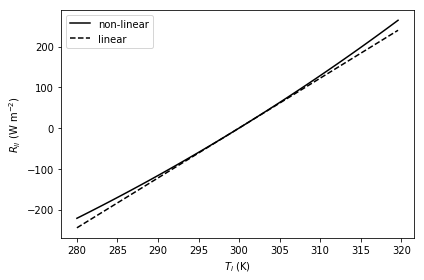

In [125]:
vdict = cdict.copy()
vdict[T_w] = 300
vdict[T_a] = 300
expr = eq_Rll.rhs.subs(vdict)
print(expr)
P = plot_expr2((T_l, 280,320), [(eq_Rll.rhs.subs(vdict), 'non-linear'),
                                (eq_Rll_tang.rhs.subs(vdict), 'linear')], yllabel='$R_{ll}$ (W m$^{-2}$)')
P

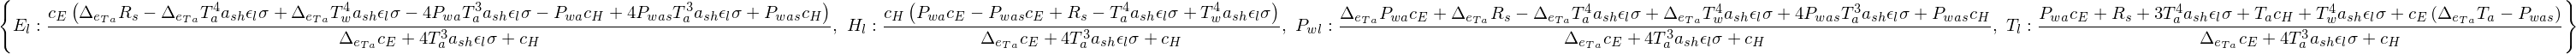

In [126]:
# More direct approach, not using gamma_v at all
soln = solve([eq_Hl_cH, eq_Penman_ass, eq_El_cE, eq_Rs_enbal.subs(eq_Rll_tang.subs(T1, T_a))], E_l, H_l, P_wl, T_l)
soln

eq_El_Delta_Rlllin
eq_El_Delta_Rlllin
eq_El_Delta_Rlllin = type('eq_El_Delta_Rlllin', (Equation,), {'__doc__': '', 'expr': Eq(E_l, c_E*(Delta_eTa*R_s - Delta_eTa*T_a**4*a_sh*epsilon_l*sigm + Delta_eTa*T_w**4*a_sh*epsilon_l*sigm - 4*P_wa*T_a**3*a_sh*epsilon_l*sigm - P_wa*c_H + 4*P_was*T_a**3*a_sh*epsilon_l*sigm + P_was*c_H)/(Delta_eTa*c_E + 4*T_a**3*a_sh*epsilon_l*sigm + c_H))})


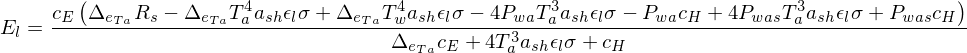

eq_Hl_Delta_Rlllin
eq_Hl_Delta_Rlllin
eq_Hl_Delta_Rlllin = type('eq_Hl_Delta_Rlllin', (Equation,), {'__doc__': '', 'expr': Eq(H_l, c_H*(P_wa*c_E - P_was*c_E + R_s - T_a**4*a_sh*epsilon_l*sigm + T_w**4*a_sh*epsilon_l*sigm)/(Delta_eTa*c_E + 4*T_a**3*a_sh*epsilon_l*sigm + c_H))})


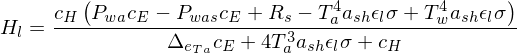

eq_Pwl_Delta_Rlllin
eq_Pwl_Delta_Rlllin
eq_Pwl_Delta_Rlllin = type('eq_Pwl_Delta_Rlllin', (Equation,), {'__doc__': '', 'expr': Eq(P_wl, (Delta_eTa*P_wa*c_E + Delta_eTa*R_s - Delta_eTa*T_a**4*a_sh*epsilon_l*sigm + Delta_eTa*T_w**4*a_sh*epsilon_l*sigm + 4*P_was*T_a**3*a_sh*epsilon_l*sigm + P_was*c_H)/(Delta_eTa*c_E + 4*T_a**3*a_sh*epsilon_l*sigm + c_H))})


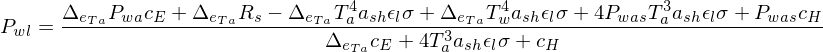

eq_Tl_Delta_Rlllin
eq_Tl_Delta_Rlllin
eq_Tl_Delta_Rlllin = type('eq_Tl_Delta_Rlllin', (Equation,), {'__doc__': '', 'expr': Eq(T_l, (P_wa*c_E + R_s + 3*T_a**4*a_sh*epsilon_l*sigm + T_a*c_H + T_w**4*a_sh*epsilon_l*sigm + c_E*(Delta_eTa*T_a - P_was))/(Delta_eTa*c_E + 4*T_a**3*a_sh*epsilon_l*sigm + c_H))})


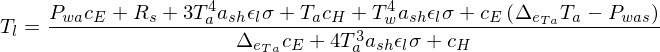

In [127]:
# More direct approach, not using gamma_v at all
soln = solve([eq_Hl_cH, eq_Penman_ass, eq_El_cE, eq_Rs_enbal.subs(eq_Rll_tang.subs(T1, T_a))], E_l, H_l, P_wl, T_l)
for var in soln.keys():
    name = 'eq_' + str(var).replace('_','') + '_Delta_Rlllin'
    print(name)
    define_equation(name, Eq(var, soln[var].subs({gamma_v: eq_gammav_cE.rhs})))
    display(eval(name))

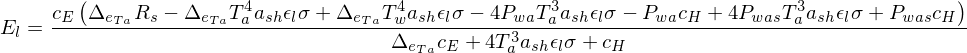

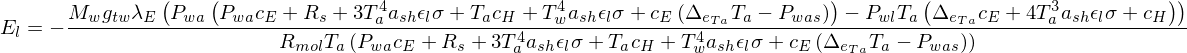

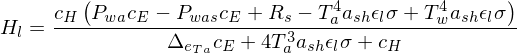

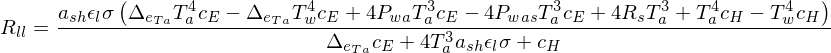

In [128]:
display(eq_El_Tl.subs(eq_Tl_Delta_Rlllin).subs(dict_eq(eq_gammav_cE)).simplify())
display(eq_El.subs(eq_Elmol).subs(dict_eq(eq_Cwa, eq_Cwl)).subs(dict_eq(eq_Tl_Delta_Rlllin)).simplify())
display(eq_Hl_cH.subs(eq_Tl_Delta_Rlllin).simplify())
display(eq_Rll_tang.subs(eq_Tl_Delta_Rlllin).simplify())

In [129]:
# Fig. 8 in Ball et al. 1988
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.07
vdict[P_a] = 101325
vdict[P_wa] = 20/1000*101325
vdict[R_s] = 400
vdict[Re_c] = 3000
vdict[T_a] = 273+30
vdict[T_w] = vdict[T_a]
vdict[g_sw] = 0.15/40
vdict[v_w] = 1.

print('\nNUMERICAL SOLUTION: ')
resdict = fun_SS(vdict)
for name1 in [T_l, E_l, H_l, R_ll, g_bw, g_tw]:
    print (str(name1)+' = ' + str(resdict[name1]))

vdict[P_was] = eq_Pwl.rhs.subs(T_l, T_a).subs(vdict) 
vdict[Delta_eTa] = eq_Deltaeta_T.rhs.subs(vdict)
vdict[k_a] = eq_ka.rhs.subs(vdict)
vdict[nu_a] = eq_nua.rhs.subs(vdict)
vdict[Re] = eq_Re.rhs.subs(vdict)
vdict[Nu] = eq_Nu_forced_all.rhs.subs(vdict)
vdict[h_c] = eq_hc.rhs.subs(vdict) 

vdict[P_N2] = eq_PN2.rhs.subs(vdict)
vdict[P_O2] = eq_PO2.rhs.subs(vdict)
vdict[alpha_a] = eq_alphaa.rhs.subs(vdict)
vdict[k_a] = eq_ka.rhs.subs(vdict)
vdict[D_va] = eq_Dva.rhs.subs(vdict)
vdict[Le] = eq_Le.rhs.subs(vdict)
vdict[rho_a] = eq_rhoa_Pwa_Ta.rhs.subs(vdict) 
vdict[g_bw] = eq_gbw_hc.rhs.subs(vdict)
vdict[g_tw] = eq_gtw.rhs.subs(vdict)
vdict[g_twmol] = eq_gtwmol_gtw_iso.rhs.subs(vdict)

vdict[R_ll] = 0
print('\nDirect T_l estimates: ')
namesdict = [E_l, H_l]
vdict[E_l] = eq_El_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
vdict[H_l] = eq_Hl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict)
for name1 in namesdict:
    print(str(name1)+' = ' + str(vdict[name1]))
    
print(eq_Tl_Delta.rhs.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict))
print(eq_Tl_Delta_a.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict))
print(eq_Tl_Delta_b.subs(dict_eq(eq_ce_conv, eq_ch_hc)).subs(vdict))
print(eq_Rs_enbal.subs(vdict))

print ('Using T_l from eq_Tl_Delta_Rlllin.rhs() only to calculate R_ll: ')
namesdict = [T_l, R_ll, E_l, H_l]
vdict[c_E] = eq_ce_conv.rhs.subs(vdict)
vdict[c_H] = eq_ch_hc.rhs.subs(vdict)
vdict[R_ll] = 0
vdict[T_l] = eq_Tl_Delta_Rlllin.rhs.subs(eq_ce_conv, eq_ch_hc).subs(vdict)
vdict[R_ll] = eq_Rll.rhs.subs(vdict)
vdict[E_l] = eq_El_Delta.rhs.subs(eq_ce_conv, eq_ch_hc).subs(vdict)
vdict[H_l] = eq_Hl_Delta.rhs.subs(eq_ce_conv, eq_ch_hc).subs(vdict)

for name1 in namesdict:
    print (str(name1)+' = ' + str(vdict[name1]))
print (eq_Rs_enbal.subs(vdict))

vdict[R_ll] = 0
print ('Penman-stomata: ')
namesdict = [E_l, H_l, T_l]
vdict[S] = eq_S_gbw_gsw.rhs.subs(vdict)
vdict[f_u] = eq_fu_gbw.rhs.subs(vdict)
vdict[gamma_v] = eq_gammav_as.rhs.subs(vdict)
vdict[E_l] = eq_El_P52.rhs.subs(vdict)
vdict[H_l] = eq_Hl_P52.rhs.subs(vdict)
vdict[T_l] = eq_Tl_P52.rhs.subs(vdict)
for name1 in namesdict:
    print (str(name1)+' = ' + str(vdict[name1]))
    
print (eq_Rs_enbal.subs(vdict))


print ('PM-equation: ')
namesdict = [E_l, H_l]
vdict[r_s] = 1/vdict[g_sw]
vdict[r_a] = eq_ra_hc.rhs.subs(vdict)
vdict[gamma_v] = eq_gammav_MU.rhs.subs(vdict)
vdict[epsilon] = eq_epsilon.rhs.subs(vdict)
vdict[E_l] = eq_El_PM2.rhs.subs(vdict)
vdict[H_l] = (R_s - R_ll - E_l).subs(vdict)

for name1 in namesdict:
    print (str(name1)+' = ' + str(vdict[name1]))
    
print (eq_Rs_enbal.subs(vdict))

print ('MU-equation: ')
namesdict = [E_l, H_l]
vdict[n_MU] = (a_sh/a_s).subs(vdict)
vdict[E_l] = eq_El_MU2.rhs.subs(vdict)
vdict[H_l] = (R_s - R_ll - E_l).subs(vdict)

for name1 in namesdict:
    print (str(name1)+' = ' + str(vdict[name1]))
    
print (eq_Rs_enbal.subs(vdict))

print ('Corrected MU-equation (eq_El_Delta_MUcorr): ')
namesdict = [E_l, H_l]
vdict[gamma_v] = eq_gammav_MU.rhs.subs(vdict)
vdict[E_l] = eq_El_Delta_MUcorr.rhs.subs(vdict)
vdict[H_l] = (R_s - R_ll - E_l).subs(vdict)

for name1 in namesdict:
    print (str(name1)+' = ' + str(vdict[name1]))
    
print (eq_Rs_enbal.subs(vdict))


print ('Corrected MU-equation (eq_El_MU_corr): ')
namesdict = [E_l, H_l]
vdict[E_l] = eq_El_MU_corr.rhs.subs(vdict)
vdict[H_l] = (R_s - R_ll - E_l).subs(vdict)

for name1 in namesdict:
    print (str(name1)+' = ' + str(vdict[name1]))
    
print (eq_Rs_enbal.subs(vdict))


NUMERICAL SOLUTION: 
T_l = 308.321395271278
E_l = 180.542235053941
H_l = 150.521099595469
R_ll = 68.9366653505872
g_bw = 0.0131620455576424
g_tw = 0.00291849206962754

Direct T_l estimates: 
E_l = 198.222104889661
H_l = 201.777895110339
310.133484539870
Eq(T_l, 310.13348453987)
Eq(T_l, 310.13348453987)
True
Using T_l from eq_Tl_Delta_Rlllin.rhs() only to calculate R_ll: 
T_l = 308.443094724766
R_ll = 70.5556017512511
E_l = 176.784812127414
H_l = 152.659586121335
True
Penman-stomata: 
E_l = 198.222104889661
H_l = 201.777895110339
T_l = 310.133484539870
False
PM-equation: 
E_l = 127153.771059783/(241.645433101007 + 177.259588325958/epsilon)
H_l = 157.117500717726
True
MU-equation: 
E_l = 127153.771059783/(241.645433101007 + 354.519176651916/epsilon)
H_l = 242.122266846530
True
Corrected MU-equation (eq_El_Delta_MUcorr): 
E_l = 195.741933442269
H_l = 204.258066557731
True
Corrected MU-equation (eq_El_MU_corr): 
E_l = 195.741933442269
H_l = 204.258066557731
True


<p><span style="color: #ff0000;">The use of the linearised R_ll improves accurcay significantly compared to eq_Tl_Delta! For some reason, the corrected MU-equation gives a different result to Penman-stomata and our general solution.</span></p>

# Exporting definitions

In [130]:
from sympy import preorder_traversal
def extract_units(expr):
    """Traverse through expression and return set of units."""
    return {
        arg
        for arg in preorder_traversal(expr) if isinstance(arg, Quantity)
    }

In [131]:
eq_Pwl_P_wet.definition.name

'eq_Pwl_P_wet'

In [132]:
with open('E_PM_eqs_defs.py', 'wt') as file1:
    file1.write('from essm.variables._core import BaseVariable, Variable\n')
    file1.write('from essm.equations import Equation\n')
    file1.write('from sympy import Abs, exp, Float, log, nsolve, Eq, sqrt, solve, Symbol\n')
    # Create import strings for all units
    StrPrinter._print_Quantity = lambda self, expr: str(expr.name)    # displays long units (meter instead of m)
    s = set()
    for unit in Variable.__units__.values():
        for item in extract_units(unit):
            s.add(item)
    commandstr = 'from sympy.physics.units import ' + str(s)[1:-1]
    file1.write(commandstr.replace("\n", " ") + "\n")
    
    for variable in Variable.__registry__.keys():
        symbol = variable.definition.latex_name
        name = variable.name
        doc = variable.__doc__
        unit = variable.definition.unit
        assumptions = variable.definition.assumptions
        latex_name = variable.definition.latex_name
        expression = Variable.__expressions__.get(variable, None)
        default = str(Variable.__defaults__.get(variable, None))
        commandstr = '''{0} = type('{0}', (Variable,), {{'__doc__': """{1}""", 'unit': {2}, 'assumptions': {3}, \
        'latex_name': r'{4}', 'default': {5}, 'expr': {6}}})'''.format(name, doc, unit, assumptions, latex_name,\
        default, expression)
        file1.write(commandstr + "\n")
        
    for eq in Equation.__registry__.keys():
        name = eq.definition.name
        doc = eq.__doc__
        equ = eq
        commandstr = '''{0} = type('{0}', (Equation,), {{'__doc__': """{1}""", 'expr': {2}}})'''.format(name, doc, equ)
        file1.write(commandstr + "\n")
        
    StrPrinter._print_Quantity = lambda self, expr: str(expr.expr)    # displays short units 

# Table of symbols

In [133]:
from essm.variables.utils import generate_metadata_table
generate_metadata_table()

Symbol,Name,Description,Definition,Default value,Units
$\alpha_a$,alpha_a,Thermal diffusivity of dry air.,$$,-,m$^{2}$ s$^{-1}$
$\alpha_l$,alpha_l,"Leaf albedo, fraction of shortwave radiation reflected by the leaf.",$$,-,1
$\beta_B$,beta_B,Bowen ratio (sensible/latent heat flux),$$,-,1
$\Delta_{e_{Ta}}$,Delta_eTa,Slope of saturation vapour pressure at air temperature,$$,-,K$^{-1}$ Pa
$\epsilon$,epsilon,Water to air molecular weight ratio (0.622),$$,0.622,1
$\epsilon_l$,epsilon_l,Longwave emmissivity of the leaf surface.,$$,1.0,1
$\gamma_v$,gamma_v,Psychrometric constant,$$,-,K$^{-1}$ Pa
$\lambda_E$,lambda_E,Latent heat of evaporation.,$$,2450000.0,J kg$^{-1}$
$\nu_a$,nu_a,Kinematic viscosity of dry air.,$$,-,m$^{2}$ s$^{-1}$
$\rho_a$,rho_a,Density of dry air.,$$,-,kg m$^{-3}$
